# 1.Research Question
The central question of this project is whether differences in tariff-related sentiment, expressed by managers in earnings disclosures, can predict firms’ cumulative abnormal returns (CAR) around earnings announcements, controlling for earnings surprises. I focus specifically on S\&P 500 firms, extracting sentiment from both earnings call transcripts and earnings press releases.

# 2.Sample and Horizon

## Environment & Global Parameters

**Purpose**: Set up Python environment, seeds, and plotting defaults.

**Outputs**: Global constants like SEED=2025.

**Notes**: Clean and sufficient for reproducibility.

In [14]:
# ==== P0. Env & Params ====
import pandas as pd, numpy as np, re, string, warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

SEED = 2025
np.random.seed(SEED)

# 小工具
def winsorize(s, p=0.01):
    if s.isnull().all(): return s
    lo, hi = s.quantile([p, 1-p])
    return s.clip(lo, hi)

def zscore(s):
    return (s - s.mean())/s.std(ddof=0)


## Data Loading (overview)

**Purpose**: Section header for loading sentence-level data, EPS surprise, and CARs.

### Load df_sents from Part 1

**Purpose**: Load sentence-level call transcript data.
**Inputs**: call_transcripts_sentences.csv.
**Outputs**: df_sents with required columns: ticker, fiscal_quarter, source_txt, part, sentence.
**Notes**: Includes normalization and length filter; good integrity check via assert.

In [15]:
# ==== P1.1 df_sents from Part 1 ====

# reading saved csv, call_transcripts_sentences is generated from get_call_transcripts.ipynb
df_sents = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/call_transcripts_sentences.csv')
required_cols = {'ticker','fiscal_quarter','source_txt','part','sentence'}
assert required_cols.issubset(df_sents.columns), f"df_sents缺列: {required_cols - set(df_sents.columns)}"

# data cleaning
def normalize(s): 
    return re.sub(r'\s+',' ', str(s).strip())
df_sents['sentence'] = df_sents['sentence'].map(normalize)
df_sents = df_sents[df_sents['sentence'].str.len()>3].copy()


### Load EPS Surprise (SUE) from part1

**Purpose**: Load EPS surprises and create a standardized SUE.

**Inputs**: eps(earnings_surprise).csv.

**Outputs**: eps_df with columns ticker, quarter, SUE.

In [4]:
# ==== P1.2 EPS (SUE) ====

# eps(earnings_surprise).csv is generated from Project1_other_part1.ipynb
eps = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/eps(earnings_surprise).csv')
if 'SUE' not in eps.columns:
    if 'sue_z' in eps.columns:
        eps['SUE'] = eps['sue_z']
    elif 'surprise_pct' in eps.columns:
        eps['SUE'] = eps.groupby('fiscal_quarter')['surprise_pct'].transform(lambda x: (x-x.mean())/x.std(ddof=0))
    else:
        eps['SUE'] = np.nan

eps_df = eps[['ticker','quarter','SUE']].drop_duplicates()


In [16]:

# ========= 1) Read Data =========
crsp = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/crsp_daily_extended.csv')
ff5  = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/FF5_extended.csv')
# After loading ff5, rename columns to match expected names
ff5 = ff5.rename(columns={
    'mktrf': 'MKT_RF',
    'smb': 'SMB',
    'hml': 'HML',
    'rmw': 'RMW',
    'cma': 'CMA',
    'rf': 'RF'
})

# Date cleaning
for df in [crsp, ff5]:
    df['date'] = pd.to_datetime(df['date'])

def detect_columns(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None


# ========= 2) Merge return and factors =========
crsp_ff = crsp.merge(ff5, on='date', how='inner')
crsp_ff['RET'] = pd.to_numeric(crsp_ff['RET'], errors='coerce')  # Convert RET to numeric, coercing strings to NaN
crsp_ff['RF'] = pd.to_numeric(crsp_ff['RF'], errors='coerce')     # Ensure RF is numeric (usually already is)
crsp_ff['excess_ret'] = crsp_ff['RET'] - crsp_ff['RF']   # 超额收益

# Detect and rename the ticker column
ticker_col = detect_columns(crsp_ff, ['TICKER', 'ticker', 'Ticker', 'symbol', 'permno'])
if ticker_col:
    crsp_ff = crsp_ff.rename(columns={ticker_col: 'ticker'})
else:
    raise ValueError("No ticker column found in df. Check df.columns.")


# ========= 3) Define Windows =========
# Main event date = press release
pr_meta = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/press_releases_meta.csv')
call_meta = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/earning_call_meta.csv')

events_pr = pr_meta[['ticker','filingDate']].rename(columns={'filingDate':'event_date'})
events_pr['event_type'] = 'press_release'

# Alternative event date = call
events_call = call_meta[['Ticker','DateTime']].rename(columns={'DateTime':'event_date'})
events_call['event_type'] = 'earnings_call'

# Merge (take what we need)
events = pd.concat([events_pr, events_call], ignore_index=True)
events['event_date'] = pd.to_datetime(events['event_date'], format='mixed')
events['ticker'] = events['ticker'].fillna(events['Ticker'])
events = events.drop(columns=['Ticker'])

# Add quarter column to events
events['quarter'] = pd.PeriodIndex(events['event_date'], freq='Q').astype(str)

# Estimation Period [-252,-30], Event Window Example [0,+1]
est_win = (-252, -30)
evt_wins = {'m01p01':(-1,1), '0p1':(0,1), '0p2':(0,2)}

# Count non-missing returns by ticker
ticker_counts = crsp_ff.groupby('ticker').apply(lambda x: x['RET'].notna().sum())
valid_tickers = ticker_counts[ticker_counts > 100].index.tolist()
print(f"Tickers with sufficient data: {len(valid_tickers)} out of {crsp_ff['ticker'].nunique()}")

# Filter the merged dataframe to only include tickers with sufficient data
crsp_ff_filtered = crsp_ff[crsp_ff['ticker'].isin(valid_tickers)].copy()

# Also filter the events dataframe to avoid processing events for invalid tickers
events_filtered = events[events['ticker'].isin(valid_tickers)].copy()

print(f"Filtered df: {len(crsp_ff_filtered)} rows vs. original {len(crsp_ff)} rows")
print(f"Filtered events: {len(events_filtered)} events vs. original {len(events)} events")

# Replace the original dataframes if you want to use the filtered versions going forward
crsp_ff = crsp_ff_filtered
events = events_filtered
# ...existing code...

Tickers with sufficient data: 528 out of 531
Filtered df: 575792 rows vs. original 576312 rows
Filtered events: 6059 events vs. original 6136 events


## Descriptive Statistics

In [ ]:
# Fix the descriptive statistics by using the correct dataset and variable names

# First, let's check what we actually have and create the proper df_main
print("Current df_main seems to be missing key variables. Let's rebuild it properly.")

# Load the components we need:
# 1. CAR data (should have been created earlier)
try:
    cars_ff5 = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/cars_ff5_processed.csv')
    print("Loaded cars_ff5:", cars_ff5.shape, "columns:", cars_ff5.columns.tolist())
except:
    print("cars_ff5 not found, using final_car from earlier")
    cars_ff5 = final_car

# 2. Tariff panel (the one we just created)
if 'tariff_panel_emb' in locals():
    print("Using tariff_panel_emb:", tariff_panel_emb.shape)
    print("Columns:", tariff_panel_emb.columns.tolist())
else:
    tariff_panel_emb = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/tariff_panel(emb_call).csv')

# 3. EPS data
try:
    eps_df = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/eps(earnings_surprise).csv')
    if 'SUE' not in eps_df.columns:
        if 'sue_z' in eps_df.columns:
            eps_df['SUE'] = eps_df['sue_z']
        elif 'surprise_pct' in eps_df.columns:
            eps_df['SUE'] = eps_df.groupby('fiscal_quarter')['surprise_pct'].transform(lambda x: (x-x.mean())/x.std(ddof=0))
    eps_df = eps_df[['ticker','quarter','SUE']].drop_duplicates()
    print("Loaded eps_df:", eps_df.shape)
except:
    print("Could not load EPS data")
    eps_df = pd.DataFrame()

# Rebuild df_main properly
if 'tariff_panel_emb' in locals() and not cars_ff5.empty:
    # Ensure consistent naming
    if 'fiscal_quarter' in tariff_panel_emb.columns:
        tariff_panel_emb = tariff_panel_emb.rename(columns={'fiscal_quarter': 'quarter'})
    
    # Merge the datasets
    df_main_new = cars_ff5.merge(tariff_panel_emb, on=['ticker','quarter'], how='inner')
    
    if not eps_df.empty:
        df_main_new = df_main_new.merge(eps_df, on=['ticker','quarter'], how='left')
    
    print("Rebuilt df_main_new:", df_main_new.shape)
    print("Columns:", df_main_new.columns.tolist())
    
    # Now create descriptive statistics with the correct variable names
    main_vars_corrected = [
        # Dependent variables (CARs) - these should exist from cars_ff5
        '0p1', 'm01p01', '0p2',
        # Control variables
        'SUE',
        # Main independent variables - adjust names to match actual columns
        'TariffSent_mean_call_all', 'TariffMentions_call_all',
        'TariffSent_mean_report_all', 'TariffMentions_report_all'  # or press_all
    ]
    
    # Filter to only include columns that actually exist
    available_vars_new = [var for var in main_vars_corrected if var in df_main_new.columns]
    
    print("\nAvailable variables for descriptive stats:")
    print(available_vars_new)
    
    if len(available_vars_new) > 0:
        # Generate descriptive statistics
        desc_stats = df_main_new[available_vars_new].describe().T
        
        # Add median explicitly
        desc_stats['median'] = df_main_new[available_vars_new].median()
        
        # Add number of non-missing observations
        desc_stats['non_missing'] = df_main_new[available_vars_new].count()
        
        # Add percentage of non-missing observations
        desc_stats['pct_non_missing'] = (df_main_new[available_vars_new].count() / len(df_main_new) * 100).round(1)
        
        # Round all numeric columns to 4 decimal places for readability
        desc_stats = desc_stats.round(4)
        
        # Reorder columns for better presentation
        desc_stats = desc_stats[['count', 'non_missing', 'pct_non_missing', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max']]
        
        # Display the table
        print("\nDescriptive Statistics for Key Variables")
        display(desc_stats)
        
        # Optional: Create a more compact version for the paper
        paper_stats = desc_stats[['count', 'mean', 'median', 'std', 'min', 'max']].round(3)
        print("\nCompact Statistics for Paper")
        display(paper_stats)
        
        # Save the statistics to a CSV file
        desc_stats.to_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/tariff_panel(emb_call).csv')
        
        # Update df_main for future use
        df_main = df_main_new
        
    else:
        print("Still no matching variables found. Let's see what we have:")
        print("Available columns in df_main_new:")
        for i, col in enumerate(df_main_new.columns):
            print(f"  {i+1:2d}. {col}")
            
else:
    print("Cannot rebuild df_main - missing required datasets")
    print("Current df_main columns:", df_main.columns.tolist())
    print("Let's work with what we have in the current df_main")
    
    # Use the closest matching variables from current df_main
    current_vars = [
        'TariffSent_mean_all', 'TariffMentions_all', 
        'TariffSent_pos_all', 'TariffSent_neg_all'
    ]
    
    available_current = [var for var in current_vars if var in df_main.columns]
    
    if len(available_current) > 0:
        desc_stats = df_main[available_current].describe().T
        desc_stats['median'] = df_main[available_current].median()
        desc_stats['non_missing'] = df_main[available_current].count()
        desc_stats['pct_non_missing'] = (df_main[available_current].count() / len(df_main) * 100).round(1)
        desc_stats = desc_stats.round(4)
        
        print("\nDescriptive Statistics (using available variables):")
        display(desc_stats)

In [16]:
add_all=pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/agg_all(18columns).csv')

In [17]:
import pandas as pd
import numpy as np

# Generate comprehensive descriptive statistics for add_all DataFrame

# First, separate numeric and categorical columns
numeric_cols = add_all.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = add_all.select_dtypes(include=['object']).columns.tolist()

# Generate descriptive stats for numeric columns
desc_stats = add_all[numeric_cols].describe()

# Add additional metrics
desc_stats.loc['median'] = add_all[numeric_cols].median()
desc_stats.loc['var'] = add_all[numeric_cols].var()
desc_stats.loc['skew'] = add_all[numeric_cols].skew()
desc_stats.loc['kurtosis'] = add_all[numeric_cols].kurtosis()
desc_stats.loc['missing'] = add_all[numeric_cols].isnull().sum()
desc_stats.loc['missing_pct'] = (add_all[numeric_cols].isnull().sum() / len(add_all) * 100).round(2)

# Add IQR (Interquartile Range)
desc_stats.loc['IQR'] = desc_stats.loc['75%'] - desc_stats.loc['25%']

# Reorder rows for better presentation
desc_stats = desc_stats.reindex(['count', 'missing', 'missing_pct', 'mean', 'std', 'var', 
                                 'min', '25%', 'median', '75%', 'max', 'IQR', 'skew', 'kurtosis'])

# For categorical columns, get frequency counts
cat_stats = {}
for col in categorical_cols:
    value_counts = add_all[col].value_counts()
    cat_stats[col] = {
        'unique_values': add_all[col].nunique(),
        'top': value_counts.index[0],
        'top_freq': value_counts.iloc[0],
        'top_pct': (value_counts.iloc[0] / len(add_all) * 100).round(2),
        'missing': add_all[col].isnull().sum(),
        'missing_pct': (add_all[col].isnull().sum() / len(add_all) * 100).round(2)
    }

# Format and round numeric values for better readability
desc_stats = desc_stats.round(4)

# Display both statistics
desc_stats.T  # Transpose for better display

NameError: name 'add_all' is not defined

In [47]:
press_desp_stats=pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/tariff_panel_merge(pr).csv')


Key Variables - Press Releases


,car_mkt_-1_+1,car_mkt_0_+1,car_mkt_0_+2,TariffMentions,TariffSent_mean,TariffSent_shareNeg,TariffSent_fwd_mean,surprise_pct,sue_z
count,2120.000000,2120.000000,2120.000000,1636.000000,70.000000,70.000000,70.000000,1849.000000,1849.000000
missing,15.000000,15.000000,15.000000,499.000000,2065.000000,2065.000000,2065.000000,286.000000,286.000000
pct_missing,0.700000,0.700000,0.700000,23.370000,96.720000,96.720000,96.720000,13.400000,13.400000
mean,0.001931,0.001294,0.002245,0.042787,-0.351781,0.571429,-0.351781,0.117557,0.005452
median,0.000000,0.000000,0.000000,0.000000,-0.454545,1.000000,-0.454545,-0.080780,-0.013674
std,0.057017,0.055278,0.056401,0.202439,0.650804,0.498445,0.650804,23.878669,1.290612
min,-0.443204,-0.406695,-0.406695,0.000000,-1.000000,0.000000,-1.000000,-439.442907,-21.918311
25%,-0.010099,-0.010101,-0.011381,0.000000,-1.000000,0.000000,-1.000000,-0.219277,-0.047284
50%,0.000000,0.000000,0.000000,0.000000,-0.454545,1.000000,-0.454545,-0.080780,-0.013674
75%,0.017141,0.015845,0.018457,0.000000,0.000000,1.000000,0.000000,0.001996,0.012838



Categorical Variables Summary

form:
  unique_values: 1
  top: 8-K
  top_freq: 2135
  top_pct: 100.0
  missing: 0
  missing_pct: 0.0

filingdate:
  unique_values: 344
  top: 5/1/25
  top_freq: 42
  top_pct: 1.97
  missing: 0
  missing_pct: 0.0

ann_time:
  unique_values: 2015
  top: 4/25/24 11:05
  top_freq: 5
  top_pct: 0.23
  missing: 0
  missing_pct: 0.0

reportdate:
  unique_values: 357
  top: 5/1/25
  top_freq: 44
  top_pct: 2.06
  missing: 0
  missing_pct: 0.0

accessionnumber:
  unique_values: 2119
  top: 0001628280-24-034974
  top_freq: 2
  top_pct: 0.09
  missing: 0
  missing_pct: 0.0

primarydocument:
  unique_values: 2109
  top: delta_8k.htm
  top_freq: 8
  top_pct: 0.37
  missing: 0
  missing_pct: 0.0

primarydocdescription:
  unique_values: 81
  top: 8-K
  top_freq: 1889
  top_pct: 88.48
  missing: 0
  missing_pct: 0.0

indexjson:
  unique_values: 2119
  top: https://www.sec.gov/Archives/edgar/data/1754301/000162828024034974/index.json
  top_freq: 2
  top_pct: 0.09
  miss

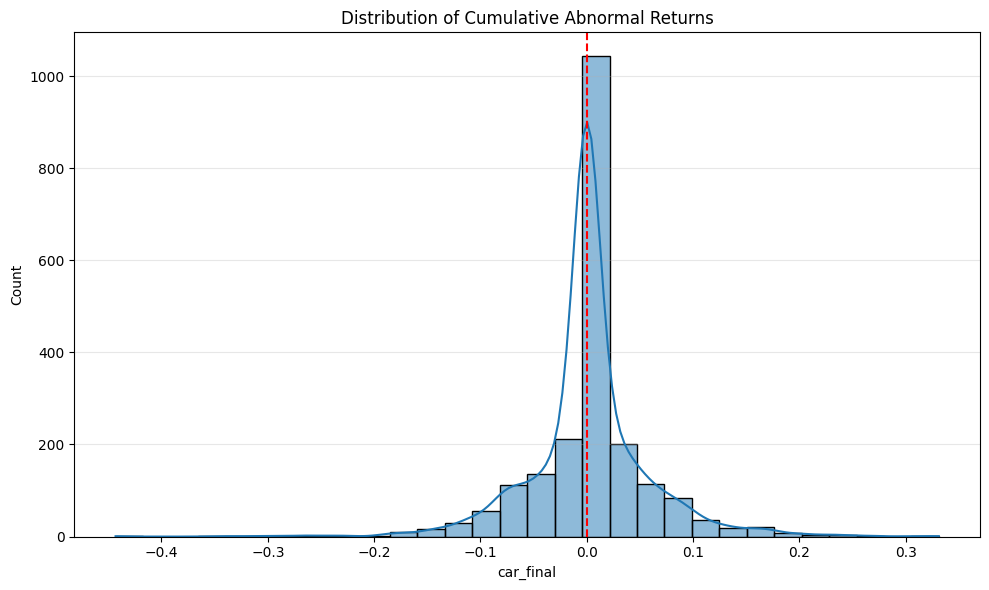

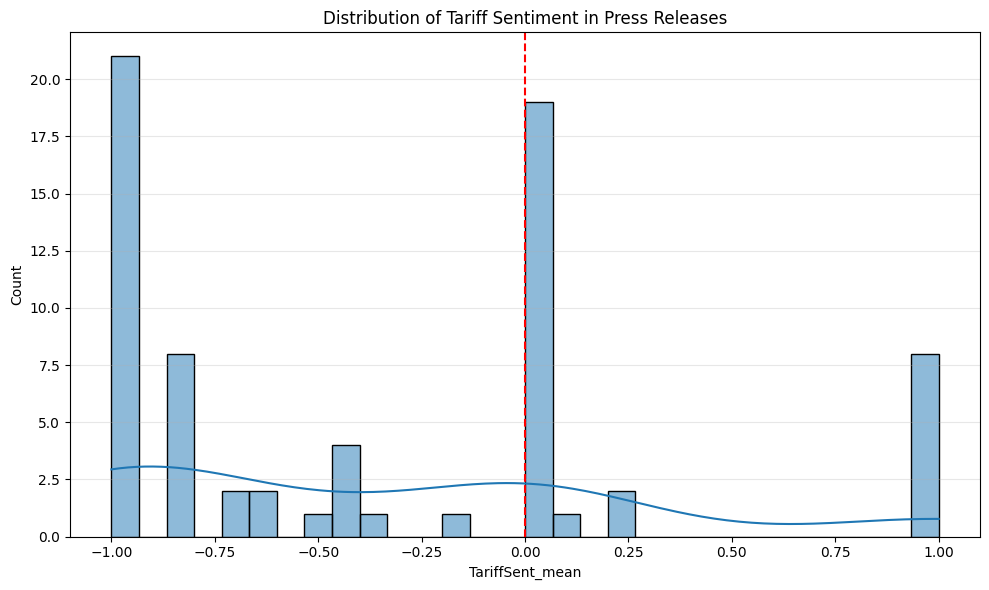


Comparison of Tariff Sentiment: Press Releases vs Earnings Calls
Press Releases mean sentiment: -0.2761
Earnings Calls mean sentiment: 0.0863
Correlation between PR and Call sentiment: -0.0762


In [48]:
# Generate comprehensive descriptive statistics for press_desp_stats

# 1. Separate numeric and categorical columns
numeric_cols = press_desp_stats.select_dtypes(include=['number']).columns.tolist()
categorical_cols = press_desp_stats.select_dtypes(include=['object', 'bool']).columns.tolist()

# 2. Generate comprehensive summary statistics for numeric columns
desc_stats = press_desp_stats[numeric_cols].describe()

# 3. Add additional statistics
desc_stats.loc['median'] = press_desp_stats[numeric_cols].median()
desc_stats.loc['missing'] = press_desp_stats[numeric_cols].isna().sum()
desc_stats.loc['pct_missing'] = (press_desp_stats[numeric_cols].isna().sum() / len(press_desp_stats) * 100).round(2)
desc_stats.loc['skewness'] = press_desp_stats[numeric_cols].skew()
desc_stats.loc['kurtosis'] = press_desp_stats[numeric_cols].kurtosis()
desc_stats.loc['IQR'] = desc_stats.loc['75%'] - desc_stats.loc['25%']

# 4. Organize rows in a logical order
desc_stats = desc_stats.reindex(['count', 'missing', 'pct_missing', 'mean', 'median', 
                               'std', 'min', '25%', '50%', '75%', 'max', 'IQR', 
                               'skewness', 'kurtosis'])

# 5. Focus on key variables
key_vars = ['car_mkt_-1_+1', 'car_mkt_0_+1', 'car_mkt_0_+2', 'TariffMentions', 
            'TariffSent_mean', 'TariffSent_shareNeg', 'TariffSent_fwd_mean', 'surprise_pct', 'sue_z']

# 6. Create a more focused table for key variables
if set(key_vars).intersection(press_desp_stats.columns):
    available_key_vars = [var for var in key_vars if var in press_desp_stats.columns]
    key_stats = desc_stats[available_key_vars]
    
    # Display the focused table
    print("\nKey Variables - Press Releases")
    display(key_stats)

# 7. Summary statistics for categorical variables
cat_stats = {}
for col in categorical_cols:
    if press_desp_stats[col].dtype == 'bool':
        # For boolean columns, show proportion of True values
        true_count = press_desp_stats[col].sum()
        cat_stats[col] = {
            'n_true': true_count,
            'pct_true': (true_count / len(press_desp_stats) * 100).round(2),
            'missing': press_desp_stats[col].isna().sum(),
            'missing_pct': (press_desp_stats[col].isna().sum() / len(press_desp_stats) * 100).round(2)
        }
    else:
        # For other categorical columns, show value counts
        value_counts = press_desp_stats[col].value_counts()
        cat_stats[col] = {
            'unique_values': press_desp_stats[col].nunique(),
            'top': value_counts.index[0] if not value_counts.empty else None,
            'top_freq': value_counts.iloc[0] if not value_counts.empty else None,
            'top_pct': (value_counts.iloc[0] / len(press_desp_stats) * 100).round(2) if not value_counts.empty else None,
            'missing': press_desp_stats[col].isna().sum(),
            'missing_pct': (press_desp_stats[col].isna().sum() / len(press_desp_stats) * 100).round(2)
        }

# Print summary for categorical variables
print("\nCategorical Variables Summary")
for col, stats in cat_stats.items():
    print(f"\n{col}:")
    for k, v in stats.items():
        print(f"  {k}: {v}")

# 8. Visualize key metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Only visualize if there's meaningful data
if 'car_final' in press_desp_stats.columns and press_desp_stats['car_final'].notna().sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.histplot(press_desp_stats['car_final'].dropna(), kde=True, bins=30)
    plt.title('Distribution of Cumulative Abnormal Returns')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
if 'TariffSent_mean' in press_desp_stats.columns and press_desp_stats['TariffSent_mean'].notna().sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.histplot(press_desp_stats['TariffSent_mean'].dropna(), kde=True, bins=30)
    plt.title('Distribution of Tariff Sentiment in Press Releases')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 9. Compare earnings calls vs press releases tariff sentiment (if both available)
if 'TariffSent_mean' in press_desp_stats.columns and 'TariffSent_mean_all' in add_all.columns:
    # First merge the relevant columns from both datasets
    try:
        merged = press_desp_stats.merge(add_all[['ticker', 'fiscal_quarter', 'TariffSent_mean_all']], 
                                      left_on=['ticker', 'quarter'], 
                                      right_on=['ticker', 'fiscal_quarter'], 
                                      how='inner')
        
        # Compare the sentiment measures
        if merged.shape[0] > 0 and merged['TariffSent_mean'].notna().sum() > 0:
            print("\nComparison of Tariff Sentiment: Press Releases vs Earnings Calls")
            print(f"Press Releases mean sentiment: {merged['TariffSent_mean'].mean():.4f}")
            print(f"Earnings Calls mean sentiment: {merged['TariffSent_mean_all'].mean():.4f}")
            
            # Correlation
            corr = merged['TariffSent_mean'].corr(merged['TariffSent_mean_all'])
            print(f"Correlation between PR and Call sentiment: {corr:.4f}")
    except:
        pass

# Save the descriptive statistics to a CSV file
desc_stats.to_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/press_release_descriptive_stats.csv')

In [ ]:

# === Cell C: Estimate betas (CAPM/FF3/FF5) then expected returns & CAR ===
import statsmodels.api as sm

# Construct CAPM/FF3/FF5 alphas & betas using estimation period data
EST_START, EST_END = -250, -30  # Relative trading day offsets from D0

# Construct Estimation Sample for (ticker, fiscal_quarter)
def collect_estimation_sample(ticker, D0):
    # Estimation period trading days: D0 + [-250, -30]
    mask = (crsp_ff["date"] >= D0 + pd.Timedelta(days=EST_START)) & \
           (crsp_ff["date"] <= D0 + pd.Timedelta(days=EST_END))
    return crsp_ff.loc[mask & (crsp_ff["ticker"]==ticker),
                       ["date","excess_ret","MKT_RF","SMB","HML","RMW","CMA"]].dropna()

# Merge excess returns and factors for each event window
events.rename(columns={'event_date':'date'}, inplace=True)
tmp = events.merge(crsp_ff, on=["ticker","date"], how="left")

def fit_and_predict(group):
    """ group: a sub-table for one (ticker, fiscal_quarter), containing several event days
        Need to first get estimation sample based on D0 in events, then fit
    """
    tkr = ticker
    fq  = quarter
    
    # Find D0
    D0_series = events.loc[(events["ticker"]==tkr)&(events["quarter"]==fq),"date"]
    if D0_series.empty or pd.isna(D0_series.iloc[0]):
        # Return the group as-is, don't add columns here
        return group
    
    D0 = pd.to_datetime(D0_series.iloc[0])
    est = collect_estimation_sample(tkr, D0)
    
    if len(est) < 50:
        # Return the group as-is
        return group

    # FF5 model
    factor_cols = ["MKT_RF","SMB","HML","RMW","CMA"]
    est_clean = est[factor_cols + ["excess_ret"]].dropna()
    
    if len(est_clean) < 50:
        return group
        
    X_ff5 = sm.add_constant(est_clean[factor_cols])
    y = est_clean["excess_ret"]
    
    try:
        ff5_model = sm.OLS(y, X_ff5).fit()
    except:
        return group

    # Store abnormal returns as attributes on the group object
    group.attrs = {}
    
    # Compute Abnormal Returns for each event window
    for w, (lo, hi) in evt_wins.items():
        evt_data = crsp_ff.loc[(crsp_ff["date"] >= D0 + pd.Timedelta(days=lo)) & 
                                (crsp_ff["date"] <= D0 + pd.Timedelta(days=hi)) & 
                                (crsp_ff["ticker"]==tkr),
                                ["date","excess_ret"] + factor_cols].dropna()
        
        if evt_data.empty:
            group.attrs[f"CAR_{w}"] = np.nan
            continue
        
        # Predict expected excess returns
        X_evt = sm.add_constant(evt_data[factor_cols])
        
        if X_evt.shape[1] != len(ff5_model.params):
            group.attrs[f"CAR_{w}"] = np.nan
            continue
            
        try:
            exp_ret = ff5_model.predict(X_evt)
            abrets = evt_data["excess_ret"] - exp_ret
            group.attrs[f"CAR_{w}"] = abrets.sum()  # Store CAR directly
        except:
            group.attrs[f"CAR_{w}"] = np.nan
    
    return group

# Apply the function and extract results
tmp['quarter'] = pd.PeriodIndex(tmp['date'], freq='Q').astype(str)

# Collect results differently
# Collect results differently - with progress bar
from tqdm.auto import tqdm

car_data = []
grouped = list(tmp.groupby(["ticker","quarter"]))
print(f"Processing {len(grouped)} ticker-quarter combinations...")


car_data = []
for (ticker, quarter), group in tqdm(grouped, desc="Calculating CARs"):
    processed_group = fit_and_predict(group)
    
    row = {'ticker': ticker, 'quarter': quarter}
    
    # Extract CARs from group attributes if they exist
    if hasattr(processed_group, 'attrs'):
        for w in evt_wins.keys():
            car_key = f"CAR_{w}"
            row[f"CAR_{w}_FF5"] = processed_group.attrs.get(car_key, np.nan)
    else:
        # No CARs calculated
        for w in evt_wins.keys():
            row[f"CAR_{w}_FF5"] = np.nan
    
    car_data.append(row)

car = pd.DataFrame(car_data)

# Continue with the rest of your renaming logic...
car_wide = car.rename(columns={
    "CAR_0p1_FF5":"CAR_01_FF5",
    "CAR_m01p01_FF5":"CAR_m1p1_FF5", 
    "CAR_0p2_FF5":"CAR_02_FF5",
})

final_car = car_wide.rename(columns={
    "CAR_01_FF5": "0p1",
    "CAR_m1p1_FF5": "m01p01",
    "CAR_02_FF5": "0p2"
})

print(f"Generated CAR data shape: {final_car.shape}")
print("Columns:", final_car.columns.tolist())

#final_car.to_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/cars_ff5_processed.csv', index=False)

In [21]:
final_car = pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/cars_ff5_processed.csv')
final_car
# m01p01 computed as the average abnormal return over the event window [-1,+1]
# 0p1 is computed as the average abnormal return over the event window [0,+1]
# 0p2 is computed as the average abnormal return over the event window [0,+2]

,ticker,quarter,m01p01,0p1,0p2
0,A,2023Q4,0.096822,0.096822,0.092801
1,A,2024Q1,0.019060,0.026450,0.032247
2,A,2024Q2,-0.124762,-0.116211,-0.135729
3,A,2024Q3,0.012284,0.007599,-0.011208
4,A,2024Q4,-0.000162,-0.000162,0.028205
...,...,...,...,...,...
3929,ZTS,2024Q3,0.063757,NaN,0.007500
3930,ZTS,2024Q4,-0.048271,NaN,-0.054573
3931,ZTS,2025Q1,NaN,NaN,NaN
3932,ZTS,2025Q2,NaN,NaN,NaN


## P2. Embedding-based Retrieval

Purpose: Describe MiniLM model and retrieval plan.

Read FF3/FF5 Daily：MktRF, SMB, HML, RMW, CMA, RF。
Merge by ticker with crsp_daily, then exret = ret_adj - RF。
Output：crsp_ff[ticker, date, exret, factors...]


* Model：all-MiniLM-L6-v2
* Seed query：
    * "tariffs on imports", "tariff headwinds", "duty relief", "exclusion expired" …

* Steps
    * Obtaining sentence embeddings
    * Calculating similarity and taking top-k or threshold
    * Combining keyword matches (tariff, duty, exclusion, 301, customs)

* Output
    * df_sents['is_tariff_related']

In [ ]:
# ==== SAFETY SWITCH: force CPU, disable MPS ====
import os, platform
# Disable MPS high watermark (optional) and directly disable MPS
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["PYTORCH_DISABLE_MPS"] = "1"   # 关键：彻底禁用 MPS

# Disable additional threads/memory usage caused by tokenizer parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OMP_NUM_THREADS"] = "1"

print("MPS disabled. Running on CPU only.")


MPS disabled. Running on CPU only.


In [ ]:
# ==== P2. Embedding-based Retrieval (OOM-safe) ====
import os, re, numpy as np
from sentence_transformers import SentenceTransformer, util
from tqdm.auto import tqdm

# 1) force CPU (avoid Mac MPS memory issues)
os.environ.pop("PYTORCH_ENABLE_MPS_FALLBACK", None)
DEVICE = "cpu"

emb_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

seed_queries = [
    "tariffs on imports","tariff headwinds","tariff tailwinds","duty relief",
    "exclusion expired","import duties increased","customs duty exemption",
    "Section 301 tariffs","trade war tariffs","countervailing duties"
]

# 2) Encode seed queries (small, won't use much memory)
seed_emb = emb_model.encode(
    seed_queries, convert_to_tensor=True, device=DEVICE,
    normalize_embeddings=True, show_progress_bar=False
)

# 3) keyword pre-filtering (hits are directly marked as related, non-hits undergo embedding similarity search)
kw_pat = re.compile(r'\b(tariff|dut(y|ies)|exclusion|301|customs)\b', flags=re.I)
kw_mask = df_sents['sentence'].str.contains(kw_pat)
df_sents['kw_hit'] = kw_mask.astype(int)

# first set the default similarity to 0, and the keyword hits to 1 (ensure they will be selected)
df_sents['tariff_sim'] = 0.0
df_sents.loc[kw_mask, 'tariff_sim'] = 1.0

# Need to do embedding only for the non-keyword-hit sentences
rest_idx = np.where(~kw_mask.values)[0]
rest_sents = df_sents.loc[rest_idx, 'sentence'].tolist()

# 4) Batch-wise embedding and similarity computation(streaming, no large matrix kept)
BATCH = 256  
max_sim_rest = np.empty(len(rest_sents), dtype=np.float32)

pbar = tqdm(range(0, len(rest_sents), BATCH), desc="Embedding (CPU, streaming)")
for j in pbar:
    batch = rest_sents[j:j+BATCH]
    emb_b = emb_model.encode(
        batch, convert_to_tensor=True, device=DEVICE,
        normalize_embeddings=True, show_progress_bar=False
    )
    sim_b = util.cos_sim(seed_emb, emb_b)                 # [n_seeds, batch]
    max_sim_rest[j:j+BATCH] = sim_b.max(dim=0).values.cpu().numpy()
    del emb_b, sim_b

# write back to the main dataframe
df_sents.loc[rest_idx, 'tariff_sim'] = max_sim_rest

# 5) Final selection based on similarity threshold or Top-K
K = 10000  
thr = np.quantile(df_sents['tariff_sim'].values, 0.98)  # Top 2% as threshold
max_sim = df_sents['tariff_sim'].values

mask_topk = np.zeros_like(max_sim, dtype=bool)
mask_topk[np.argsort(-max_sim)[:K]] = True

df_sents['is_tariff_related'] = (
    (df_sents['tariff_sim'] >= thr) | mask_topk | (df_sents['kw_hit'] == 1)
).astype(int)

print("Done. tariff-related ratio =",
      df_sents['is_tariff_related'].mean().round(4),
      " | kw_hit ratio =", df_sents['kw_hit'].mean().round(4))


Embedding (CPU, streaming): 100%|██████████| 6017/6017 [1:48:44<00:00,  1.08s/it]  


Done. tariff-related ratio = 0.02  | kw_hit ratio = 0.0033


In [10]:
max_sim

array([0.18156379, 0.17038138, 0.0970815 , ..., 0.12716489, 0.1701777 ,
       0.19121261], shape=(1545280,))

In [ ]:
# Save results
# df_sents.to_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/call_transcripts_sentences_with_retrieval.csv', index=False)
# np.save('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/call_transcripts_sentences_max_sim.npy', max_sim)

## P3. FinBERT Scoring

* Model：yiyanghkust/finbert-tone
* Socre all tariff-related sentences → Get fb_pos, fb_neg, fb_neu

* construct benchmark：
    * fb_score = pos - neg
    * fb_fwd = forward-looking dummy（include next, expect, guidance, outlook…）

* merging 
    * ticker × fiscal_quarter × (report/call, prep/qna)

* Output：
    * tariff_panel_emb，含 TariffSent_mean_call_all/prep/qna，TariffMentions_call_all，TariffSent_fwd_call_all，以及 report 对应列

In [22]:
# Read back the saved results

df_sents=pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/call_transcripts_sentences_with_retrieval.csv')

In [ ]:
# ==== P3. FinBERT scoring & Aggregation ====
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import numpy as np
from tqdm.auto import tqdm

finbert_name = "yiyanghkust/finbert-tone"
tok = AutoTokenizer.from_pretrained(finbert_name)
mdl = AutoModelForSequenceClassification.from_pretrained(finbert_name)

# device=-1 => CPU
finbert = TextClassificationPipeline(model=mdl, tokenizer=tok, return_all_scores=True, truncation=True)

sub = df_sents[df_sents['is_tariff_related']==1].copy()

def finbert_scores(texts, batch_size=32):
    neg, neu, pos = [], [], []
    # progress bar over batches
    for i in tqdm(range(0, len(texts), batch_size), desc="FinBERT scoring", unit="batch"):
        batch = texts[i:i+batch_size]
        out = finbert(batch)
        for row in out:
            d = {x['label'].lower(): x['score'] for x in row}
            neg.append(d.get('negative',0.0))
            neu.append(d.get('neutral',0.0))
            pos.append(d.get('positive',0.0))
    return np.array(neg), np.array(neu), np.array(pos)

neg, neu, pos = finbert_scores(sub['sentence'].tolist(), batch_size=64)
sub['fb_neg'], sub['fb_neu'], sub['fb_pos'] = neg, neu, pos
sub['fb_score'] = sub['fb_pos'] - sub['fb_neg']
sub['fb_fwd'] = sub['sentence'].str.contains(r'\b(next|expect|guidance|outlook|forecast|going forward|plan|will)\b', flags=re.I).astype(int)



In [ ]:
# Save results
# This dataframe contains only tariff-related sentences with FinBERT scores
sub.to_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/temp_with_finbert.csv', index=False)

In [23]:
# Load data with FinBERT scores
sub=pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/temp_with_finbert.csv')
sub

,ticker,fiscal_quarter,source_txt,part,sentence,kw_hit,tariff_sim,is_tariff_related,fb_neg,fb_neu,fb_pos,fb_score,fb_fwd
0,ABNB,2025Q1,call,qna,We're taking a much more localized approach to...,0,0.393816,1,0.000054,0.999899,0.000047,-0.000008,0
1,ABNB,2025Q1,call,qna,"On the expansion markets, what would I say?",0,0.383223,1,0.000151,0.999844,0.000005,-0.000146,0
2,ABNB,2025Q1,call,qna,One is There is underlying real price apprecia...,0,0.546806,1,0.000132,0.003466,0.996403,0.996271,0
3,ABNB,2025Q1,call,qna,There is a movement in terms of the FX headwind.,0,0.467700,1,0.948985,0.051010,0.000006,-0.948979,0
4,ABNB,2025Q1,call,qna,And then the third component is as our busines...,0,0.593012,1,0.994767,0.005225,0.000008,-0.994759,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30901,ZTS,2025Q1,call,prep,"First, it seems like the Trump administration ...",0,0.464338,1,0.030425,0.969517,0.000058,-0.030366,0
30902,ZTS,2025Q1,call,prep,pet products could be excluded from broader se...,0,0.543908,1,0.007310,0.991528,0.001162,-0.006148,0
30903,ZTS,2025Q1,call,prep,on the issue of the 232 sectoral tariffs on ph...,0,0.563337,1,0.913080,0.086885,0.000035,-0.913045,0
30904,ZTS,2025Q1,call,prep,"75% of what we sell in the United States, we m...",0,0.410540,1,0.000016,0.999973,0.000012,-0.000004,0


In [24]:
# ==== Aggregation & Merging ====
def norm_src(x):
    x = (x or '').lower()
    if 'press' in x or 'report' in x: return 'report'
    return 'call'
def norm_part(x):
    x = (x or '').lower()
    if 'q' in x: return 'qna'
    return 'prep'

sub['source'] = sub['source_txt'].map(norm_src)
sub['part']   = sub['part'].map(norm_part)


agg_cols = {'fb_score':'mean','fb_neg':'mean','fb_pos':'mean','fb_fwd':'mean','sentence':'count'}
g_all  = sub.groupby(['ticker','fiscal_quarter','source']).agg(agg_cols).rename(columns={'sentence':'n_sent'}).reset_index()
g_part = sub.groupby(['ticker','fiscal_quarter','source','part']).agg(agg_cols).rename(columns={'sentence':'n_sent'}).reset_index()

g_all = g_all.rename(columns={
    'fb_score':'TariffSent_mean_all','fb_neg':'TariffSent_neg_all','fb_pos':'TariffSent_pos_all',
    'fb_fwd':'TariffSent_fwd_all','n_sent':'TariffMentions_all'
})

g_part.pivot(index=['ticker','fiscal_quarter','source'], columns='part')

fb_score              fb_neg            \
part                              prep       qna      prep       qna   
ticker fiscal_quarter source                                           
A      2024Q1         call         NaN -0.249974       NaN  0.499975   
       2024Q2         call         NaN -0.406864       NaN  0.407343   
       2024Q3         call         NaN -0.200202       NaN  0.400480   
       2024Q4         call         NaN -0.161033       NaN  0.161085   
       2025Q1         call         NaN -0.274754       NaN  0.421107   
...                                ...       ...       ...       ...   
ZTS    2024Q2         call   -0.999640       NaN  0.999724       NaN   
       2024Q3         call   -0.409715       NaN  0.521649       NaN   
       2024Q4         call   -0.229442       NaN  0.504961       NaN   
       2025Q1         call    0.051031       NaN  0.078837       NaN   
       2025Q2         call   -0.163743       NaN  0.380697       NaN   

                                fb_pos              fb_fwd           n_sent  \
part                              prep       qna      prep       qna   prep   
ticker fiscal_quarter source                                                  
A      2024Q1         call         NaN  0.250001       NaN  0.500000    NaN   
       2024Q2         call         NaN  0.000478       NaN  0.000000    NaN   
       2024Q3         call         NaN  0.200277       NaN  0.400000    NaN   
       2024Q4         call         NaN  0.000052       NaN  0.076923    NaN   
       2025Q1         call         NaN  0.146354       NaN  0.190476    NaN   
...                                ...       ...       ...       ...    ...   
ZTS    2024Q2         call    0.000085       NaN  0.000000       NaN    1.0   
       2024Q3         call    0.111934       NaN  0.222222       NaN    9.0   
       2024Q4         call    0.275520       NaN  0.250000       NaN    8.0   
       2025Q1         call    0.129869       NaN  0.294118       NaN   34.0   
       2025Q2         call    0.216954       NaN  0.176471       NaN   17.0   

                                    
part                           qna  
ticker fiscal_quarter source        
A      2024Q1         call     4.0  
       2024Q2         call     5.0  
       2024Q3         call     5.0  
       2024Q4         call    13.0  
       2025Q1         call    21.0  
...                            ...  
ZTS    2024Q2         call     NaN  
       2024Q3         call     NaN  
       2024Q4         call     NaN  
       2025Q1         call     NaN  
       2025Q2         call     NaN  

[3033 rows x 10 columns]

In [25]:
# ==== Aggregation & Merging ====
def norm_src(x):
    x = (x or '').lower()
    if 'press' in x or 'report' in x: return 'report'
    return 'call'
def norm_part(x):
    x = (x or '').lower()
    if 'q' in x: return 'qna'
    return 'prep'

sub['source'] = sub['source_txt'].map(norm_src)
sub['part']   = sub['part'].map(norm_part)

agg_cols = {'fb_score':'mean','fb_neg':'mean','fb_pos':'mean','fb_fwd':'mean','sentence':'count'}
g_all  = sub.groupby(['ticker','fiscal_quarter','source']).agg(agg_cols).rename(columns={'sentence':'n_sent'}).reset_index()
g_part = sub.groupby(['ticker','fiscal_quarter','source','part']).agg(agg_cols).rename(columns={'sentence':'n_sent'}).reset_index()

g_all = g_all.rename(columns={
    'fb_score':'TariffSent_mean_all','fb_neg':'TariffSent_neg_all','fb_pos':'TariffSent_pos_all',
    'fb_fwd':'TariffSent_fwd_all','n_sent':'TariffMentions_all'
})

# safer pivot/unstack + flatten columns (handles missing parts)
pivot_part = g_part.set_index(['ticker','fiscal_quarter','source','part']).unstack('part')
# flatten MultiIndex columns to e.g. "fb_score_prep", "fb_neg_qna"
pivot_part.columns = [f"{col[0]}_{col[1]}" for col in pivot_part.columns]
pivot_part = pivot_part.reset_index()

agg_df = g_all.merge(pivot_part, on=['ticker','fiscal_quarter','source'], how='left')

# build a wide table where 'source' is unstacked (keeps call & report rows)
wide_src = agg_df.set_index(['ticker','fiscal_quarter','source']).unstack('source')
# flatten MultiIndex columns like ('TariffSent_mean_all','call') -> 'TariffSent_mean_all_call'
wide_src.columns = [f"{col[0]}_{col[1]}" for col in wide_src.columns]
wide_src = wide_src.reset_index()

def extract_src(df_wide, src='call'):
    # mapping from wide column names to desired final names
    mapping = {
        f"TariffSent_mean_all_{src}": f"TariffSent_mean_{src}_all",
        f"TariffSent_neg_all_{src}":  f"TariffSent_neg_{src}_all",
        f"TariffSent_pos_all_{src}":  f"TariffSent_pos_{src}_all",
        f"TariffSent_fwd_all_{src}":  f"TariffSent_fwd_{src}_all",
        f"TariffMentions_all_{src}":  f"TariffMentions_{src}_all",
        f"fb_score_prep_{src}":       f"TariffSent_mean_{src}_prep",
        f"fb_score_qna_{src}":        f"TariffSent_mean_{src}_qna",
    }
    present = {k:v for k,v in mapping.items() if k in df_wide.columns}
    cols = ['ticker','fiscal_quarter'] + list(present.keys())
    out = df_wide[cols].rename(columns=present)
    return out

agg_call = extract_src(wide_src, 'call')
agg_report = extract_src(wide_src, 'report')

# merge call & report on ticker × fiscal_quarter
tariff_panel_emb = pd.merge(agg_call, agg_report, on=['ticker','fiscal_quarter'], how='outer')

In [54]:
tariff_panel_emb

,ticker,fiscal_quarter,TariffSent_mean_call_all,TariffSent_neg_call_all,TariffSent_pos_call_all,TariffSent_fwd_call_all,TariffMentions_call_all,TariffSent_mean_call_prep,TariffSent_mean_call_qna
0,A,2024Q1,-0.249974,0.499975,0.250001,0.500000,4,NaN,-0.249974
1,A,2024Q2,-0.406864,0.407343,0.000478,0.000000,5,NaN,-0.406864
2,A,2024Q3,-0.200202,0.400480,0.200277,0.400000,5,NaN,-0.200202
3,A,2024Q4,-0.161033,0.161085,0.000052,0.076923,13,NaN,-0.161033
4,A,2025Q1,-0.274754,0.421107,0.146354,0.190476,21,NaN,-0.274754
...,...,...,...,...,...,...,...,...,...
3028,ZTS,2024Q2,-0.999640,0.999724,0.000085,0.000000,1,-0.999640,NaN
3029,ZTS,2024Q3,-0.409715,0.521649,0.111934,0.222222,9,-0.409715,NaN
3030,ZTS,2024Q4,-0.229442,0.504961,0.275520,0.250000,8,-0.229442,NaN
3031,ZTS,2025Q1,0.051031,0.078837,0.129869,0.294118,34,0.051031,NaN


In [59]:
press=pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/tariff_panel_merge(pr).csv')
press

,cik,form,filingdate,ann_time,reportdate,accessionnumber,primarydocument,primarydocdescription,indexjson,docurl,...,car_window,quarter,TariffMentions,TariffSent_mean,TariffSent_shareNeg,TariffSent_fwd_mean,surprise_pct,sue_z,GICS_Sector,GICS_SubIndustry
0,1090872,8-K,8/27/25,8/27/25 20:06,8/27/25,0001090872-25-000034,a-20250827.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,...,"(-1,1)",2025Q3,NaN,NaN,NaN,NaN,NaN,NaN,Health Care,Life Sciences Tools & Services
1,1090872,8-K,5/28/25,5/28/25 20:06,5/28/25,0001090872-25-000013,a-20250528.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,...,"(-1,1)",2025Q2,NaN,NaN,NaN,NaN,-0.050269,-0.041543,Health Care,Life Sciences Tools & Services
2,1090872,8-K,2/26/25,2/26/25 21:05,2/26/25,0001090872-25-000003,a-20250226.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,...,"(-1,1)",2025Q1,NaN,NaN,NaN,NaN,-0.050269,-0.057802,Health Care,Life Sciences Tools & Services
3,1090872,8-K,11/25/24,11/25/24 21:06,11/25/24,0001090872-24-000042,a-20241125.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,...,"(-1,1)",2024Q4,NaN,NaN,NaN,NaN,0.038168,0.031690,Health Care,Life Sciences Tools & Services
4,1090872,8-K,8/21/24,8/21/24 20:06,8/21/24,0001090872-24-000024,a-20240821.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,...,"(-1,1)",2024Q3,NaN,NaN,NaN,NaN,0.046154,-0.001481,Health Care,Life Sciences Tools & Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,1512673,8-K,11/7/24,11/7/24 21:13,11/7/24,0001193125-24-253135,d835206d8k.htm,8-K,https://www.sec.gov/Archives/edgar/data/151267...,https://www.sec.gov/Archives/edgar/data/151267...,...,failed,2024Q4,NaN,NaN,NaN,NaN,NaN,NaN,Financials,Transaction & Payment Processing Services
2131,1512673,8-K,8/1/24,8/1/24 20:16,8/1/24,0001193125-24-191530,d750402d8k.htm,8-K,https://www.sec.gov/Archives/edgar/data/151267...,https://www.sec.gov/Archives/edgar/data/151267...,...,failed,2024Q3,NaN,NaN,NaN,NaN,NaN,NaN,Financials,Transaction & Payment Processing Services
2132,1512673,8-K,5/2/24,5/2/24 20:19,5/2/24,0001193125-24-129385,d831696d8k.htm,8-K,https://www.sec.gov/Archives/edgar/data/151267...,https://www.sec.gov/Archives/edgar/data/151267...,...,failed,2024Q2,NaN,NaN,NaN,NaN,NaN,NaN,Financials,Transaction & Payment Processing Services
2133,1512673,8-K,2/22/24,2/22/24 21:11,2/22/24,0001193125-24-042835,d718674d8k.htm,8-K,https://www.sec.gov/Archives/edgar/data/151267...,https://www.sec.gov/Archives/edgar/data/151267...,...,failed,2024Q1,NaN,NaN,NaN,NaN,NaN,NaN,Financials,Transaction & Payment Processing Services


In [28]:
## A) Standardize press_release_panel (rename columns & merge with EPS & CARs)
press=pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/tariff_panel_merge(pr).csv')

# ==== P4. Merge with EPS & CARs ====

# 2) Standardize keys: ticker & fiscal_quarter
press['ticker'] = press['ticker'].astype(str).str.upper()

def to_quarter(q):
    q = str(q)
    if 'Q' in q:
        return q
    try:
        return pd.Period(pd.to_datetime(q), freq='Q').strftime('%YQ%q')
    except:
        return q

press['fiscal_quarter'] = press['quarter'].map(to_quarter)

# 3) Keep only needed columns, add 'press' suffix
keep_cols = [
    'ticker','fiscal_quarter','ann_time','t0','after_hours',
    'car_mkt_-1_+1','car_mkt_0_+1','car_mkt_0_+2','car_final','car_window',
    'TariffMentions','TariffSent_mean','TariffSent_shareNeg','TariffSent_fwd_mean',
    'surprise_pct','sue_z', 'GICS_Sector'  # keep sector for later use
]
press_std = press[keep_cols].copy()

press_std = press_std.rename(columns={
    'TariffMentions':      'TariffMentions_press_all',
    'TariffSent_mean':     'TariffSent_mean_press_all',
    'TariffSent_shareNeg': 'TariffSent_shareNeg_press_all',
    'TariffSent_fwd_mean': 'TariffSent_fwd_press_all',
    'car_mkt_-1_+1':       'CAR_press_mkt_m01p01',
    'car_mkt_0_+1':        'CAR_press_mkt_0p1',
    'car_mkt_0_+2':        'CAR_press_mkt_0p2',
    'sue_z':               'SUE'  
})

# If multiple press releases for the same (ticker, fiscal_quarter), keep the most recent one
press_std = (press_std
             .sort_values(['ticker','fiscal_quarter','ann_time']))
print("press_std:", press_std.shape)

press_std


press_std: (2135, 17)


,ticker,fiscal_quarter,ann_time,t0,after_hours,CAR_press_mkt_m01p01,CAR_press_mkt_0p1,CAR_press_mkt_0p2,car_final,car_window,TariffMentions_press_all,TariffSent_mean_press_all,TariffSent_shareNeg_press_all,TariffSent_fwd_press_all,surprise_pct,SUE,GICS_Sector
7,A,2023Q4,11/20/23 21:06,11/21/23,True,0.095014,0.087754,0.087754,0.095014,"(-1,1)",NaN,NaN,NaN,NaN,-0.036900,-0.042752,Health Care
6,A,2024Q1,2/27/24 21:06,2/28/24,True,0.044204,0.036172,0.048469,0.044204,"(-1,1)",NaN,NaN,NaN,NaN,-0.007299,0.058783,Health Care
5,A,2024Q2,5/29/24 20:06,5/30/24,True,-0.122695,-0.104350,-0.104350,-0.122695,"(-1,1)",NaN,NaN,NaN,NaN,-0.010909,0.003988,Health Care
4,A,2024Q3,8/21/24 20:06,8/22/24,True,0.007905,0.006242,0.006242,0.007905,"(-1,1)",NaN,NaN,NaN,NaN,0.046154,-0.001481,Health Care
3,A,2024Q4,11/25/24 21:06,11/26/24,True,0.031973,0.027159,0.027159,0.031973,"(-1,1)",NaN,NaN,NaN,NaN,0.038168,0.031690,Health Care
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2131,XYZ,2024Q3,8/1/24 20:16,8/2/24,True,NaN,NaN,NaN,NaN,failed,NaN,NaN,NaN,NaN,NaN,NaN,Financials
2130,XYZ,2024Q4,11/7/24 21:13,11/8/24,True,NaN,NaN,NaN,NaN,failed,NaN,NaN,NaN,NaN,NaN,NaN,Financials
2129,XYZ,2025Q1,2/20/25 21:20,2/21/25,True,NaN,NaN,NaN,NaN,failed,NaN,NaN,NaN,NaN,-0.239278,-0.164073,Financials
2128,XYZ,2025Q2,5/1/25 20:11,5/2/25,True,NaN,NaN,NaN,NaN,failed,NaN,NaN,NaN,NaN,-0.219907,-0.051468,Financials


## P4. Portrayal 图（Cell 8）

这里直接使用 tariff_panel_emb，画时序/行业/Prepared vs Q&A（我之前给过完整代码，你可以原样粘贴）。如果你只想保留时序与Q&A差异，把行业部分注释掉。

In [29]:
tariff_panel_emb

,ticker,fiscal_quarter,TariffSent_mean_call_all,TariffSent_neg_call_all,TariffSent_pos_call_all,TariffSent_fwd_call_all,TariffMentions_call_all,TariffSent_mean_call_prep,TariffSent_mean_call_qna
0,A,2024Q1,-0.249974,0.499975,0.250001,0.500000,4,NaN,-0.249974
1,A,2024Q2,-0.406864,0.407343,0.000478,0.000000,5,NaN,-0.406864
2,A,2024Q3,-0.200202,0.400480,0.200277,0.400000,5,NaN,-0.200202
3,A,2024Q4,-0.161033,0.161085,0.000052,0.076923,13,NaN,-0.161033
4,A,2025Q1,-0.274754,0.421107,0.146354,0.190476,21,NaN,-0.274754
...,...,...,...,...,...,...,...,...,...
3028,ZTS,2024Q2,-0.999640,0.999724,0.000085,0.000000,1,-0.999640,NaN
3029,ZTS,2024Q3,-0.409715,0.521649,0.111934,0.222222,9,-0.409715,NaN
3030,ZTS,2024Q4,-0.229442,0.504961,0.275520,0.250000,8,-0.229442,NaN
3031,ZTS,2025Q1,0.051031,0.078837,0.129869,0.294118,34,0.051031,NaN


In [30]:
press_std.rename(columns={'fiscal_quarter': 'quarter'}, inplace=True)
tariff_panel_emb.rename(columns={'fiscal_quarter': 'quarter'}, inplace=True)

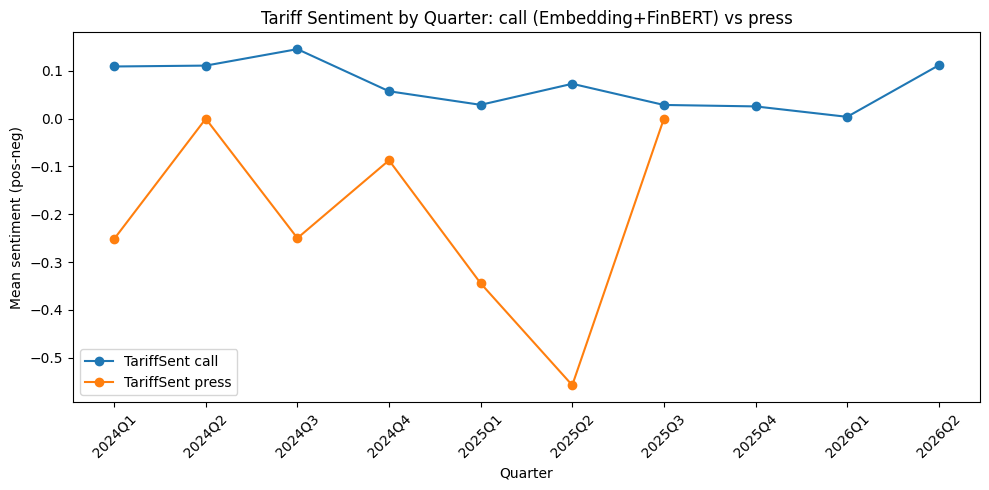

In [31]:
# 1) Merge call & press panels for comparison
compare_df = tariff_panel_emb.merge(
    press_std[['ticker','quarter',
               'TariffSent_mean_press_all','TariffMentions_press_all',
               'CAR_press_mkt_0p1','CAR_press_mkt_m01p01','CAR_press_mkt_0p2']],
    on=['ticker','quarter'], how='left'
)

# 2) Portrayal：quarterly mean comparison (press vs call)
plot_ts = (compare_df.groupby('quarter')
           [['TariffSent_mean_call_all','TariffSent_mean_press_all']]
           .mean().reset_index())

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for col in ['TariffSent_mean_call_all','TariffSent_mean_press_all']:
    if col in plot_ts.columns:
        plt.plot(plot_ts['quarter'], plot_ts[col], marker='o', label=col.replace('_mean_',' ').replace('_all',''))
plt.title("Tariff Sentiment by Quarter: call (Embedding+FinBERT) vs press")
plt.xlabel("Quarter"); plt.ylabel("Mean sentiment (pos-neg)"); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


## P5. Baseline Regression 


In [32]:
# ==== P5. Baseline Regression ====
# 合并
tariff_panel_emb.rename(columns={'fiscal_quarter':'quarter'}, inplace=True)
df_main = cars_ff5.merge(tariff_panel_emb, on=['ticker','quarter'], how='inner') \
                  .merge(eps_df,        on=['ticker','quarter'], how='left')

# 设主口径（call_all），若缺则回退 report_all
tone_col = 'TariffSent_mean_call_all' if 'TariffSent_mean_call_all' in df_main.columns else 'TariffSent_mean_report_all'
ment_col = 'TariffMentions_call_all'  if 'TariffMentions_call_all'  in df_main.columns else 'TariffMentions_report_all'

# 标准化/去极值
for c in ['0p1','m01p01','0p2', tone_col, ment_col, 'SUE']:
    if c in df_main.columns and pd.api.types.is_numeric_dtype(df_main[c]):
        df_main[c] = winsorize(df_main[c], 0.01)

import statsmodels.formula.api as smf

formula = f"Q('0p1') ~ {tone_col} + {ment_col} + SUE + C(quarter)"
dfr = df_main.dropna(subset=['0p1', tone_col, 'SUE'])
m_main = smf.ols(formula, data=dfr).fit(cov_type='cluster', cov_kwds={'groups': dfr['ticker']})
print(m_main.summary())


                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8239
Date:                Fri, 03 Oct 2025   Prob (F-statistic):              0.552
Time:                        11:32:03   Log-Likelihood:                 1090.7
No. Observations:                 838   AIC:                            -2167.
Df Residuals:                     831   BIC:                            -2134.
Df Model:                           6                                         
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## P6. Robustness

In [71]:
# ==== P6. Robustness ====
def run_win(win):
    if win not in df_main.columns: return
    f = formula.replace("Q('0p1')", f"Q('{win}')")
    dfx = df_main.dropna(subset=[win, tone_col, 'SUE'])
    if len(dfx)<80: return
    m = smf.ols(f, data=dfx).fit(cov_type='cluster', cov_kwds={'groups': dfx['ticker']})
    print(f"\n=== Window {win} ===")
    print(m.summary())

for w in ['m01p01','0p2']:
    run_win(w)

# Anchor points (if there are source_txt markers)
if 'source_txt' in cars_ff5.columns:
    for src in ['press','call']:
        dfx = df_main[df_main['source_txt'].str.lower()==src]
        if len(dfx)<80: continue
        m = smf.ols(formula, data=dfx).fit(cov_type='cluster', cov_kwds={'groups': dfx['ticker']})
        print(f"\n=== Anchor {src} ===")
        print(m.summary())



=== Window m01p01 ===
                            OLS Regression Results                            
Dep. Variable:            Q('m01p01')   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.613
Date:                Fri, 03 Oct 2025   Prob (F-statistic):             0.0168
Time:                        11:24:28   Log-Likelihood:                 2239.2
No. Observations:                1727   AIC:                            -4464.
Df Residuals:                    1720   BIC:                            -4426.
Df Model:                           6                                         
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

In [72]:
import linearmodels as lm
from linearmodels.panel import PanelOLS
import pandas as pd
import numpy as np
from datetime import datetime

# === Two-way clustering (firm & event date) ===
import statsmodels.api as sm

# 1. Prepare data for two-way clustering
df_panel = df_main.copy()

# Convert fiscal_quarter to event_date for clustering
# First ensure we have the PR or call date to use as event date
if 'date' in df_panel.columns:
    df_panel['event_date'] = pd.to_datetime(df_panel['date'])
elif 'ann_time' in df_panel.columns:
    df_panel['event_date'] = pd.to_datetime(df_panel['ann_time'])
else:
    # If no exact date, use quarter end as proxy
    df_panel['event_date'] = pd.to_datetime(df_panel['quarter'].str.replace('Q', '-') + '-01')
    df_panel['event_date'] = df_panel['event_date'] + pd.offsets.QuarterEnd(0)

# 2. Run regression with two-way clustering using linearmodels
try:
    # Create a copy for linearmodels
    df_lm = df_panel.copy()
    
    # Ensure we have the required columns
    required_cols = [tone_col, ment_col, 'SUE', '0p1', 'ticker', 'event_date']
    df_lm = df_lm.dropna(subset=required_cols)
    
    # Set multi-index for linearmodels
    df_lm = df_lm.set_index(['ticker', 'event_date'])
    
    # Create formula
    formula = f"Q('0p1') ~ 1 + Q('{tone_col}') + Q('{ment_col}') + SUE"
    
    # Run pooled OLS with two-way clustering
    mod = lm.panel.PooledOLS.from_formula(formula, data=df_lm)
    res = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
    
    print("\n=== Two-way Clustering with linearmodels ===")
    print(res.summary)
    
except Exception as e:
    print(f"linearmodels implementation failed: {e}")
    
    # Fallback: Try simple one-way clustering by firm
    try:
        # Reset data
        df_simple = df_main.copy()
        
        # Basic regression with firm clustering only
        X = df_simple[[tone_col, ment_col, 'SUE']].copy()
        X = sm.add_constant(X)
        y = df_simple['0p1']
        
        # Drop missing values
        valid = ~(X.isna().any(axis=1) | y.isna())
        X_clean = X[valid]
        y_clean = y[valid]
        firm_clusters = df_simple.loc[valid, 'ticker'].values
        
        # Simple OLS with firm clustering
        model = sm.OLS(y_clean, X_clean)
        results = model.fit(cov_type='cluster', cov_kwds={'groups': firm_clusters})
        
        print("\n=== Fallback: One-way Clustered Standard Errors (Firm Only) ===")
        print(results.summary())
        
    except Exception as e2:
        print(f"Fallback also failed: {e2}")
        print("Unable to perform clustered regression analysis")


=== Two-way Clustering with linearmodels ===
                          PooledOLS Estimation Summary                          
Dep. Variable:               Q('0p1')   R-squared:                        0.0039
Estimator:                  PooledOLS   R-squared (Between):              0.0081
No. Observations:                 838   R-squared (Within):               0.0011
Date:                Fri, Oct 03 2025   R-squared (Overall):              0.0039
Time:                        11:24:33   Log-likelihood                    1089.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.0810
Entities:                         234   P-value                           0.3563
Avg Obs:                       3.5812   Distribution:                   F(3,834)
Min Obs:                       1.0000                                           
Max Obs:                       4.0000   F-statistic (robust):  

In [179]:
from tqdm.auto import tqdm

# === Alternative Expected-Return Model: Market Model ===
import statsmodels.api as sm

# Function to calculate market model CARs
def calculate_market_model_cars(crsp_ff, events, evt_wins={'m01p01':(-1,1), '0p1':(0,1), '0p2':(0,2)}):
    """
    Calculate cumulative abnormal returns using the market model (CAPM)
    
    Parameters:
    -----------
    crsp_ff : DataFrame with stock and market returns
    events : DataFrame with event dates
    evt_wins : dict of event windows to calculate CARs for
    
    Returns:
    --------
    DataFrame with market model CARs for each ticker-quarter
    """
    EST_START, EST_END = -250, -30  # Estimation window relative to event date
    
    # Function to collect estimation sample
    def collect_estimation_sample(ticker, D0):
        mask = (crsp_ff["date"] >= D0 + pd.Timedelta(days=EST_START)) & \
               (crsp_ff["date"] <= D0 + pd.Timedelta(days=EST_END))
        return crsp_ff.loc[mask & (crsp_ff["ticker"]==ticker),
                          ["date","excess_ret","MKT_RF"]].dropna()
    
    # Prepare result container
    car_data = []
    
    # Group by ticker and quarter
    grouped = list(events.groupby(["ticker","quarter"]))
    print(f"Processing {len(grouped)} ticker-quarter combinations...")
    
    # Process each group
    for (ticker, quarter), group in tqdm(grouped, desc="Calculating Market Model CARs"):
        row = {'ticker': ticker, 'quarter': quarter}
        
        # Find event date
        D0_series = group["date"]
        if D0_series.empty or pd.isna(D0_series.iloc[0]):
            car_data.append(row)
            continue
        
        D0 = pd.to_datetime(D0_series.iloc[0])
        
        # Get estimation sample
        est = collect_estimation_sample(ticker, D0)
        
        if len(est) < 50:
            car_data.append(row)
            continue
        
        # Run market model regression
        X = sm.add_constant(est["MKT_RF"])
        y = est["excess_ret"]
        
        try:
            model = sm.OLS(y, X).fit()
        except:
            car_data.append(row)
            continue
        
        # Calculate CAR for each event window
        for w, (lo, hi) in evt_wins.items():
            # Get event window data
            evt_data = crsp_ff.loc[(crsp_ff["date"] >= D0 + pd.Timedelta(days=lo)) & 
                                  (crsp_ff["date"] <= D0 + pd.Timedelta(days=hi)) & 
                                  (crsp_ff["ticker"]==ticker),
                                  ["date","excess_ret","MKT_RF"]].dropna()
            
            if evt_data.empty:
                row[f"CAR_{w}_MKT"] = np.nan
                continue
            
            # Predict expected returns with market model
            X_evt = sm.add_constant(evt_data["MKT_RF"])
            
            try:
                exp_ret = model.predict(X_evt)
                abrets = evt_data["excess_ret"] - exp_ret
                row[f"CAR_{w}_MKT"] = abrets.sum()
            except:
                row[f"CAR_{w}_MKT"] = np.nan
        
        car_data.append(row)
    
    # Create DataFrame from results
    car_mkt = pd.DataFrame(car_data)
    
    # Rename columns for consistency with FF5 results
    car_mkt_wide = car_mkt.rename(columns={
        "CAR_0p1_MKT": "0p1_MKT",
        "CAR_m01p01_MKT": "m01p01_MKT", 
        "CAR_0p2_MKT": "0p2_MKT",
    })
    
    print(f"Generated Market Model CAR data shape: {car_mkt_wide.shape}")
    
    return car_mkt_wide

# Calculate market model CARs
car_mkt_model = calculate_market_model_cars(crsp_ff, events)

# Compare to FF5 model results
# Merge with original data
merged_car = final_car.merge(car_mkt_model, on=['ticker', 'quarter'], how='outer')

# Display sample of results
print("\nSample of merged CAR data:")
print(merged_car.sample(5))

# Calculate correlations between models
print("\nCorrelations between FF5 and Market Model CARs:")
for window in ['0p1', '0p2', 'm01p01']:
    if f"{window}_MKT" in merged_car.columns and window in merged_car.columns:
        corr = merged_car[[window, f"{window}_MKT"]].corr().iloc[0,1]
        print(f"{window}: {corr:.4f}")

# Run the main regression with market model CAR
if 'TariffSent_mean_call_all' in df_main.columns and '0p1_MKT' in merged_car.columns:
    # Create new dataframe with market model CARs
    df_mkt = df_main.merge(car_mkt_model[['ticker', 'quarter', '0p1_MKT']], 
                          on=['ticker', 'quarter'], how='inner')
    
    # Run regression
    formula_mkt = f"Q('0p1_MKT') ~ {tone_col} + {ment_col} + SUE + C(quarter)"
    dfr_mkt = df_mkt.dropna(subset=['0p1_MKT', tone_col, 'SUE'])
    
    if len(dfr_mkt) > 80:
        m_mkt = smf.ols(formula_mkt, data=dfr_mkt).fit(
            cov_type='cluster', cov_kwds={'groups': dfr_mkt['ticker']}
        )
        print("\n=== Market Model Regression ===")
        print(m_mkt.summary())

Processing 3934 ticker-quarter combinations...


Calculating Market Model CARs: 100%|██████████| 3934/3934 [05:51<00:00, 11.19it/s]


Generated Market Model CAR data shape: (3934, 5)

Sample of merged CAR data:
     ticker quarter    m01p01       0p1       0p2  m01p01_MKT   0p1_MKT  \
3522     TT  2024Q3  0.001826       NaN -0.018912    0.011545       NaN   
3286    STX  2025Q1       NaN       NaN       NaN         NaN       NaN   
463    BIIB  2025Q3       NaN       NaN       NaN         NaN       NaN   
25     ABNB  2024Q1  0.004816 -0.034748  0.016665    0.012193 -0.028919   
1         A  2024Q1  0.019060  0.026450  0.032247    0.038481  0.040900   

       0p2_MKT  
3522 -0.017733  
3286       NaN  
463        NaN  
25    0.022887  
1     0.038940  

Correlations between FF5 and Market Model CARs:
0p1: 0.9877
0p2: 0.9830
m01p01: 0.9856

=== Market Model Regression ===
                            OLS Regression Results                            
Dep. Variable:           Q('0p1_MKT')   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:     

## P7. Heterogeneity

In [86]:

# ==== P7. Heterogeneity ====
dfx = df_main.copy()
dfx['has_tariff'] = (dfx[ment_col] > 0).astype(int)

# 子样本（has_tariff = 1） — dropna before fitting
d1 = dfx[dfx['has_tariff']==1].dropna(subset=["0p1", tone_col, "SUE", "quarter"]).reset_index(drop=True)
if len(d1) > 0:
    m1 = smf.ols(formula, data=d1).fit(cov_type='cluster', cov_kwds={'groups': d1['ticker'].values})
    print("\n=== Only has_tariff==1 ===")
    print(m1.summary())
else:
    print("\n=== Only has_tariff==1: no observations ===")



=== Only has_tariff==1 ===
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.209
Date:                Fri, 26 Sep 2025   Prob (F-statistic):              0.300
Time:                        17:44:59   Log-Likelihood:                 4076.7
No. Observations:                2642   AIC:                            -8139.
Df Residuals:                    2635   BIC:                            -8098.
Df Model:                           6                                         
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [87]:
# 交互（tone × has_tariff）
dfx['tone_x_has'] = dfx[tone_col] * dfx['has_tariff']
f2 = f"Q('0p1') ~ has_tariff + tone_x_has + SUE + C(quarter)"
d2 = dfx.dropna(subset=["0p1","has_tariff","tone_x_has","SUE","quarter", tone_col]).reset_index(drop=True)
if len(d2) > 0:
    m2 = smf.ols(f2, data=d2).fit(cov_type='cluster', cov_kwds={'groups': d2['ticker'].values})
    print("\n=== Interaction: tone × has_tariff ===")
    print(m2.summary())
else:
    print("\n=== Interaction: tone × has_tariff: no observations ===")



=== Interaction: tone × has_tariff ===
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                  0.002880
Date:                Fri, 26 Sep 2025   Prob (F-statistic):              0.957
Time:                        17:45:10   Log-Likelihood:                 4076.1
No. Observations:                2642   AIC:                            -8138.
Df Residuals:                    2635   BIC:                            -8097.
Df Model:                           6                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [88]:
# 高暴露 vs 低暴露（以 mentions 分位做 proxy）
cut = dfx[ment_col].quantile(0.75)
dfx['high_mentions'] = (dfx[ment_col] >= cut).astype(int)
f3 = f"Q('0p1') ~ {tone_col}*high_mentions + SUE + C(quarter)"
d3 = dfx.dropna(subset=["0p1", tone_col, "high_mentions", "SUE", "quarter"]).reset_index(drop=True)
if len(d3) > 0:
    m3 = smf.ols(f3, data=d3).fit(cov_type='cluster', cov_kwds={'groups': d3['ticker'].values})
    print("\n=== High vs Low Mentions (interaction) ===")
    print(m3.summary())
else:
    print("\n=== High vs Low Mentions (interaction): no observations ===")
# ...existing



=== High vs Low Mentions (interaction) ===
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                    0.9938
Date:                Fri, 26 Sep 2025   Prob (F-statistic):              0.435
Time:                        17:45:12   Log-Likelihood:                 4076.9
No. Observations:                2642   AIC:                            -8138.
Df Residuals:                    2634   BIC:                            -8091.
Df Model:                           7                                         
Covariance Type:              cluster                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

## P8. Rerun Regression on Press

In [49]:
import pandas as pd
import statsmodels.formula.api as smf


# ==== 加载 press 面板 ====
tariff_press = pd.read_csv("/Users/sally/Desktop/Fall2025/NLP/Project_1/results/tariff_panel_merge(pr).csv")

# 合并 press 面板 + CAR + EPS
df_press = cars_ff5.merge(tariff_press, on=['ticker','quarter'], how='inner') \
                   .merge(eps_df, on=['ticker','quarter'], how='left')

# 确认列名（可能是 TariffSent_mean_report_all / TariffSent_mean_press_all）
print(df_press.columns.tolist())
# （这里你文件里的 quarter 列是 fiscal_quarter，对齐一下）
df_press = df_press.rename(columns={'quarter':'fiscal_quarter'})

# 去极值（winsorize）
for c in ['0p1','m01p01','0p2','TariffSent_mean','TariffMentions','SUE']:
    if c in df_press.columns:
        lo, hi = df_press[c].quantile([0.01,0.99])
        df_press[c] = df_press[c].clip(lo, hi)

# --- 基准回归（window 0p1） ---
formula_p = "Q('0p1') ~ TariffSent_mean + TariffMentions + SUE + C(fiscal_quarter)"
dfr_p = df_press.dropna(subset=['0p1','TariffSent_mean','SUE'])
m_press = smf.ols(formula_p, data=dfr_p).fit(
    cov_type='cluster', cov_kwds={'groups': dfr_p['ticker']}
)
print("\n=== Baseline Regression (press) ===")
print(m_press.summary())


['ticker', 'quarter', 'm01p01', '0p1', '0p2', 'cik', 'form', 'filingdate', 'ann_time', 'reportdate', 'accessionnumber', 'primarydocument', 'primarydocdescription', 'indexjson', 'docurl', 'exhibit99url', 'itemsraw', 'ann_date', 'after_hours', 't0', 'car_mkt_-1_+1', 'car_mkt_0_+1', 'car_mkt_0_+2', 'car_final', 'car_window', 'TariffMentions', 'TariffSent_mean', 'TariffSent_shareNeg', 'TariffSent_fwd_mean', 'surprise_pct', 'sue_z', 'GICS_Sector', 'GICS_SubIndustry', 'SUE']

=== Baseline Regression (press) ===
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                     8.569
Date:                Fri, 03 Oct 2025   Prob (F-statistic):            0.00352
Time:                        11:46:51   Log-Likelihood:                 33.276
No. Observation

In [51]:
# --- 稳健性（不同事件窗） ---
for w in ['m01p01','0p2']:
    if w in df_press.columns:
        f = formula_p.replace("Q('0p1')", f"Q('{w}')")
        dfx = df_press.dropna(subset=[w,'TariffSent_mean','SUE'])
        if len(dfx) > 80:
            m = smf.ols(f, data=dfx).fit(cov_type='cluster', cov_kwds={'groups': dfx['ticker']})
            print(f"\n=== Robustness (press, window {w}) ===")
            print(m.summary())

In [52]:

# --- 异质性分析 (robust to NA / cluster length mismatch) ---
dfp = df_press.copy()
dfp['has_tariff'] = (dfp['TariffMentions'] > 0).astype(int)
dfp['tone_x_has'] = dfp['TariffSent_mean'] * dfp['has_tariff']

# (1) 子样本 — drop rows with NA in any variable used by formula_p
vars_p = ['0p1','TariffSent_mean','TariffMentions','SUE','fiscal_quarter','ticker']
sub1 = dfp[dfp['has_tariff']==1].dropna(subset=vars_p).reset_index(drop=True)
print("Heterogeneity (press) sub1 rows:", len(sub1))
if len(sub1) > 0:
    m1 = smf.ols(formula_p, data=sub1).fit(
        cov_type='cluster', cov_kwds={'groups': sub1['ticker'].values}
    )
    print("\n=== Heterogeneity (press, has_tariff=1) ===")
    print(m1.summary())
else:
    print("\n=== Heterogeneity (press, has_tariff=1): no observations ===")

Heterogeneity (press) sub1 rows: 25

=== Heterogeneity (press, has_tariff=1) ===
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                     8.569
Date:                Fri, 03 Oct 2025   Prob (F-statistic):            0.00352
Time:                        11:47:25   Log-Likelihood:                 33.276
No. Observations:                  25   AIC:                            -52.55
Df Residuals:                      18   BIC:                            -44.02
Df Model:                           6                                         
Covariance Type:              cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

In [53]:
# (2) 交互 — ensure NA-free on vars used in f2
f2 = "Q('0p1') ~ has_tariff + tone_x_has + SUE + C(fiscal_quarter)"
vars_f2 = ['0p1','has_tariff','tone_x_has','SUE','fiscal_quarter','ticker']
sub2 = dfp.dropna(subset=vars_f2).reset_index(drop=True)
print("Heterogeneity (press) sub2 rows:", len(sub2))
if len(sub2) > 0:
    m2 = smf.ols(f2, data=sub2).fit(
        cov_type='cluster', cov_kwds={'groups': sub2['ticker'].values}
    )
    print("\n=== Heterogeneity (press, interaction) ===")
    print(m2.summary())
else:
    print("\n=== Heterogeneity (press, interaction): no observations ===")

Heterogeneity (press) sub2 rows: 25

=== Heterogeneity (press, interaction) ===
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                     8.569
Date:                Fri, 03 Oct 2025   Prob (F-statistic):            0.00352
Time:                        11:47:27   Log-Likelihood:                 33.276
No. Observations:                  25   AIC:                            -52.55
Df Residuals:                      18   BIC:                            -44.02
Df Model:                           6                                         
Covariance Type:              cluster                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

In [54]:


# (3) 高 vs 低 mentions — ensure NA-free on vars used in f3
cut = dfp['TariffMentions'].quantile(0.75)
dfp['high_mentions'] = (dfp['TariffMentions'] >= cut).astype(int)
f3 = "Q('0p1') ~ TariffSent_mean*high_mentions + SUE + C(fiscal_quarter)"
vars_f3 = ['0p1','TariffSent_mean','high_mentions','SUE','fiscal_quarter','ticker']
sub3 = dfp.dropna(subset=vars_f3).reset_index(drop=True)
print("Heterogeneity (press) sub3 rows:", len(sub3))
if len(sub3) > 0:
    m3 = smf.ols(f3, data=sub3).fit(
        cov_type='cluster', cov_kwds={'groups': sub3['ticker'].values}
    )
    print("\n=== Heterogeneity (press, high vs low mentions) ===")
    print(m3.summary())
else:
    print("\n=== Heterogeneity (press, high vs low mentions): no observations ===")
# ...existing


Heterogeneity (press) sub3 rows: 25

=== Heterogeneity (press, high vs low mentions) ===
                            OLS Regression Results                            
Dep. Variable:               Q('0p1')   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                     8.065
Date:                Fri, 03 Oct 2025   Prob (F-statistic):            0.00429
Time:                        11:47:29   Log-Likelihood:                 33.276
No. Observations:                  25   AIC:                            -52.55
Df Residuals:                      18   BIC:                            -44.02
Df Model:                           6                                         
Covariance Type:              cluster                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  warnings.warn('covariance of constraints does not have full '


In [49]:
dfp.to_parquet('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/press_sentences_with_finbert.parquet', index=False)

In [ ]:
# ### P4.x WordCloud Utils (Enhanced with multiple stop word sources)
# This Module: Imports, Stopwords, Keywords, Helper Functions (Freq Count, Weighting, Plotting)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import re

# Import additional stop word sources
try:
    import nltk
    from nltk.corpus import stopwords
    # Download if not already present
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    NLTK_STOPWORDS = set(stopwords.words('english'))
    print(f"NLTK stopwords loaded: {len(NLTK_STOPWORDS)}")
except ImportError:
    NLTK_STOPWORDS = set()
    print("NLTK not available")

try:
    import spacy
    nlp = spacy.load('en_core_web_sm')
    SPACY_STOPWORDS = nlp.Defaults.stop_words
    print(f"spaCy stopwords loaded: {len(SPACY_STOPWORDS)}")
except (ImportError, OSError):
    SPACY_STOPWORDS = set()
    print("spaCy not available")

# Sentence-level sentiment thresholds (>0.2 positive, <-0.2 negative; avoid neutral noise)
POS_THR, NEG_THR = 0.20, -0.20


NLTK stopwords loaded: 179
spaCy not available


In [36]:
# Enhanced stop words combining multiple sources with singular/plural and tense variations

# Enhanced stop words combining multiple sources
FINANCIAL_STOP = {
    # Basic corporate terms (singular and plural)
    'company','companies','business','businesses','management','quarter','quarters','year','years','fiscal',
    'million','millions','billion','billions','percent','per','share','shares','earning','earnings','eps',
    'guidance','outlook','outlooks','forward','statement','statements','safe','harbor',
    'press','release','releases','today','announced','announce','report','reports','reported','reporting','including',
    'related','relate','relates','result','results','condition','conditions','change','changes','changed','changing',
    'ability','abilities','potential','factor','factors','information','product','products','service','services',
    'operation','operations','market','markets','cost','costs','basis','compared','compare','comparing',
    'primarily','driven','drive','drives','total','adjusted','adjust','adjusting','income',
    'revenue','revenues','sale','sales','increased','increase','increases','increasing','net','operating','operate',
    'performance','perform','performed','performing','period','periods','second','fourth','prior','ended','end','versus',
    
    # Communication patterns in earnings calls
    'analyst','analysts','call','calls','conference','conferences','question','questions','answer','answers','answered','answering',
    'thank','thanks','thanked','thanking','good','morning','afternoon','evening','operator','operators',
    'participant','participants','folk','folks','everyone','team','teams','discussion','discussions',
    'comment','comments','commented','commenting','remark','remarks','remarked','remarking',
    'presentation','presentations','slide','slides','deck','decks','material','materials','appreciate','appreciated','appreciating',
    
    # Time and sequence words
    'first','second','third','next','last','previous','following','current','recent','recently',
    'future','going','forward','ahead','back','ago','since','during','throughout','within','across','between','among',
    'around','approximately','roughly','about','nearly','almost','close','significant','significantly',
    
    # Generic qualifiers
    'obviously','clearly','certainly','absolutely','definitely','specifically','generally','typically',
    'usually','normally','traditionally','historically','essentially','basically','fundamentally',
    'ultimately','overall','broadly','particularly','especially','importantly','notably','really','quite','pretty',
    'fairly','relatively','somewhat','rather','probably','likely','maybe','perhaps','possibly','potentially',
    'hopefully','unfortunately','fortunately',
    
    # Financial metrics
    'dollar','dollars','usd','cent','cents','basis','point','points','bps','margin','margins',
    'ebitda','ebit','gaap','non','adj','core','underlying','normalized','organic','pro','forma','like',
    'growth','grow','grew','grown','growing','decline','declined','declining','improvement','improve','improved','improving',
    'deterioration','deteriorate','deteriorated','deteriorating','impact','impacts','impacted','impacting',
    'effect','effects','affected','affecting','benefit','benefits','benefited','benefiting',
    
    # Legal boilerplate
    'disclaimer','disclaimers','actual','differ','differed','differing','materially','expectation','expectations',
    'projection','projections','estimate','estimates','estimated','estimating','assumption','assumptions',
    'risk','risks','uncertainty','uncertainties','sec','filing','filings','filed','regulatory','compliance','legal',
    
    # Generic terms that don't add meaning (with variations)
    'kind','kinds','sort','sorts','type','types','way','ways','thing','things','lot','lots',
    'number','numbers','level','levels','extent','degree','term','terms','case','cases',
    'situation','situations','circumstance','circumstances','condition','conditions',
    'environment','environments','context','contexts','perspective','perspectives','standpoint','standpoints',
    'regard','regards','respected','respecting','area','areas','space','spaces',
    'we\'re','we\'ve','you\'re','it\'s','that\'s','there\'s','what\'s','who\'s','let\'s',
    'think','thinks','thought','thinking','know','knows','knew','known','knowing',
    'understand','understands','understood','understanding','see','sees','saw','seen','seeing',
    'look','looks','looked','looking','feel','feels','felt','feeling',
    'believe','believes','believed','believing','guess','guesses','guessed','guessing',
    'wonder','wonders','wondered','wondering','mean','means','meant','meaning',
    'realize','realizes','realized','realizing','recognize','recognizes','recognized','recognizing',
    'consider','considers','considered','considering','imagine','imagines','imagined','imagining',
    'suppose','supposes','supposed','supposing','assume','assumes','assumed','assuming',
    'expect','expects','expected','expecting',
    
    # Communication fillers and transitions
    'talk','talks','talked','talking','discuss','discusses','discussed','discussing',
    'mention','mentions','mentioned','mentioning','note','notes','noted','noting',
    'point','points','pointed','pointing','show','shows','showed','showing','shown'
}

# Tariff-related terms to preserve and potentially weight 
# - keep these OUT of stop words (with variations)

TARIFF_KWS = {
    'tariff','tariffs','duty','duties','custom','customs','trade','trades','traded','trading',
    'exclusion','exclusions','exclude','excluded','excluding',
    'import','imports','imported','importing','export','exports','exported','exporting',
    'headwind','headwinds','tailwind','tailwinds',
    'china','chinese','section','301','ustr','wto','nafta','usmca','tpp',
    'steel','aluminum','agriculture','agricultural','manufacturing','manufacture','manufactured',
    'supply','supplies','supplied','supplying','chain','chains','chained','chaining'
}

# Additional industry-specific terms to preserve (with variations)
PRESERVE_KWS = {
    'manufacturing','manufacture','manufactured','manufactures','supply','supplies','supplied','supplying',
    'chain','chains','chained','chaining','source','sources','sourced','sourcing',
    'procurement','procure','procured','procuring','logistics','logistic',
    'freight','freights','ship','ships','shipped','shipping','transport','transports','transported','transporting',
    'transportation','inventory','inventories','raw','material','materials',
    'commodity','commodities','steel','aluminum','agriculture','agricultural',
    'china','chinese','asia','asian','europe','european','north','america','american',
    'mexico','mexican','canada','canadian'
}

# Combine all stop word sources
ALL_STOPWORDS = set(ENGLISH_STOP_WORDS) | NLTK_STOPWORDS | SPACY_STOPWORDS | FINANCIAL_STOP

# Final stopwords list - remove any words we want to preserve
STOPWORDS = [word for word in ALL_STOPWORDS 
             if word.lower() not in TARIFF_KWS and word.lower() not in PRESERVE_KWS]

print(f"Total stop words from all sources: {len(ALL_STOPWORDS)}")
print(f"Final stopwords after removing protected keywords: {len(STOPWORDS)}")
print(f"Protected tariff keywords: {len(TARIFF_KWS)}")
print(f"Protected industry keywords: {len(PRESERVE_KWS)}")

# Show examples of the variations we added
print("\nExample variations added:")
print("- headwind/headwinds, tailwind/tailwinds")
print("- import/imports/imported/importing") 
print("- supply/supplies/supplied/supplying")
print("- manufacture/manufacturing/manufactured")
print("- expect/expects/expected/expecting")
print("- result/results, report/reports/reported/reporting")

# Rest of your functions remain the same
def normalize_text(s: str) -> str:
    return re.sub(r'\s+',' ', str(s).strip())

def build_ngram_freq(texts, stopwords=STOPWORDS, ngram=(1,2), min_df=2):
    """Convert a list of texts into a {ngram: frequency} dictionary"""
    if not texts:
        return {}
    vec = CountVectorizer(lowercase=True,
                          stop_words=stopwords,
                          token_pattern=r"[A-Za-z][A-Za-z\-']+",
                          ngram_range=ngram,
                          min_df=min_df,
                          max_features=5000)
    X = vec.fit_transform(texts)
    vocab = np.array(vec.get_feature_names_out())
    counts = np.asarray(X.sum(axis=0)).ravel()
    return dict(zip(vocab, counts))

def boost_keywords(freq_dict, keywords=TARIFF_KWS, factor=3.0):
    """Boost weights of n-grams containing any of the specified keywords by a given factor."""
    out = {}
    for k, v in freq_dict.items():
        toks = set(k.split())
        out[k] = v * factor if keywords.intersection(toks) else v
    return out

def make_wordcloud_from_freq(freq, title, cmap, max_words=200):
    """Generate word cloud from frequency dictionary"""
    if not freq:
        print(f"No words to display for {title}")
        return
        
    wc = WordCloud(
        width=900, 
        height=600, 
        background_color="white", 
        colormap=cmap,
        max_words=max_words,
        relative_scaling=0.5,
        min_font_size=10
    )
    
    try:
        wc_img = wc.generate_from_frequencies(freq)
        plt.imshow(wc_img, interpolation='bilinear')
        plt.axis("off")
        plt.title(title, fontsize=16)
    except ValueError as e:
        print(f"Error generating word cloud for {title}: {e}")

def prep_df_for_wc(df, source_label):
    """
    Standardize the input sentence-level DataFrame:
    Must contain columns: sentence and fb_score or (fb_pos, fb_neg)
    Add column: source, to label 'call' or 'press'
    """
    d = df.copy()
    d['sentence'] = d['sentence'].map(normalize_text)
    if 'fb_score' not in d.columns:
        if {'fb_pos','fb_neg'}.issubset(d.columns):
            d['fb_score'] = d['fb_pos'].astype(float) - d['fb_neg'].astype(float)
        else:
            raise ValueError("需要列 fb_score 或 (fb_pos, fb_neg) 以区分正负句。")
    d['source'] = source_label
    d = d.dropna(subset=['sentence','fb_score'])
    return d

Total stop words from all sources: 797
Final stopwords after removing protected keywords: 795
Protected tariff keywords: 51
Protected industry keywords: 57

Example variations added:
- headwind/headwinds, tailwind/tailwinds
- import/imports/imported/importing
- supply/supplies/supplied/supplying
- manufacture/manufacturing/manufactured
- expect/expects/expected/expecting
- result/results, report/reports/reported/reporting


In [62]:
# ### P4.x Load & Prep
# This module standardizes the input sentence-level DataFrames for calls and press releases to a uniform structure for subsequent word cloud generation.
# Each DataFrame is expected to have at least: sentence, and either fb_score or (fb_pos, fb_neg). If sentiment scores are not yet available, you can run the previous FinBERT scoring.

call_sents=pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/temp_with_finbert.csv')
press_sents=pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/press_sentences_with_finbert.csv')
# press_sents: press release sentence-level data (with FinBERT scores)
# call_sents: earnings call sentence-level data (with FinBERT scores)

call_wc_df  = prep_df_for_wc(call_sents,  source_label='call')
press_wc_df = prep_df_for_wc(press_sents, source_label='press')

print("call_wc_df:",  call_wc_df.shape, "| columns:", list(call_wc_df.columns)[:8], "...")
print("press_wc_df:", press_wc_df.shape, "| columns:", list(press_wc_df.columns)[:8], "...")


call_wc_df: (30906, 16) | columns: ['ticker', 'fiscal_quarter', 'source_txt', 'part', 'sentence', 'kw_hit', 'tariff_sim', 'is_tariff_related'] ...
press_wc_df: (9382, 13) | columns: ['ticker', 'fiscal_quarter', 'sentence', 'source', 'kw_hit', 'tariff_sim', 'is_tariff_related', 'fb_neg'] ...


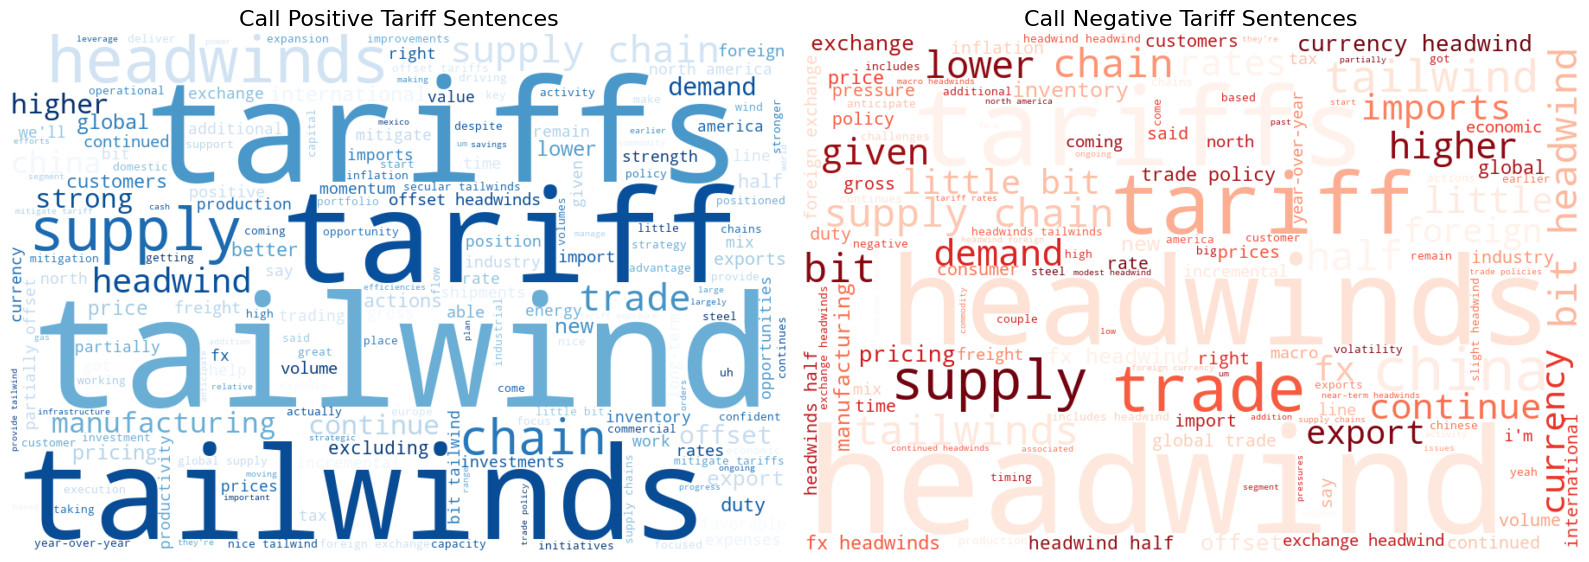

[Call] Positive sentences: 8638 | Negative sentences: 7339


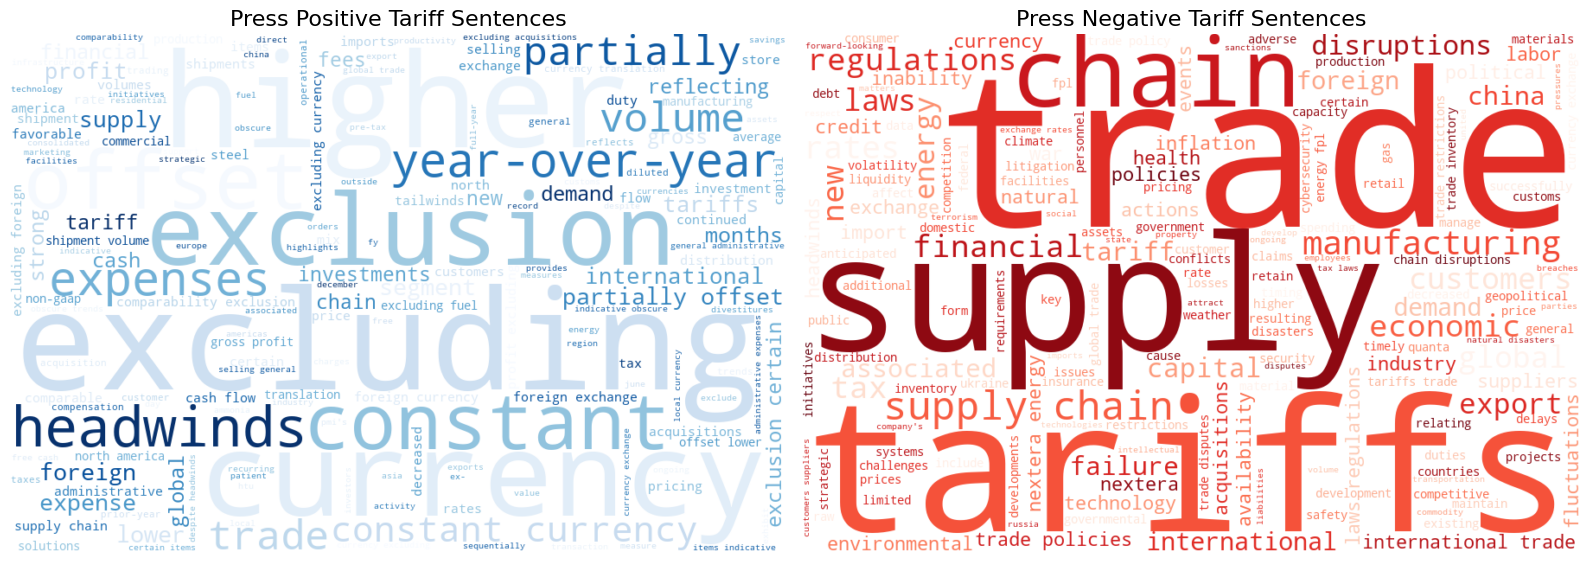

[Press] Positive sentences: 3738 | Negative sentences: 1242


In [57]:
# ### P4.x WordClouds (single function for both call & press)
# This module generates and displays positive and negative word clouds for both earnings call and press release sentences, using the standardized DataFrames prepared earlier.

def plot_pos_neg_wordclouds(df, title_prefix=""):
    pos_texts = df.loc[df['fb_score'] >  POS_THR, 'sentence'].tolist()
    neg_texts = df.loc[df['fb_score'] <  NEG_THR, 'sentence'].tolist()
    pos_freq  = boost_keywords(build_ngram_freq(pos_texts))
    neg_freq  = boost_keywords(build_ngram_freq(neg_texts))

    fig = plt.figure(figsize=(16,7))
    plt.subplot(1,2,1); make_wordcloud_from_freq(pos_freq, f"{title_prefix} Positive Tariff Sentences", cmap="Blues")
    plt.subplot(1,2,2); make_wordcloud_from_freq(neg_freq, f"{title_prefix} Negative Tariff Sentences", cmap="Reds")
    plt.tight_layout(); plt.show()

    print(f"[{title_prefix}] Positive sentences: {len(pos_texts)} | Negative sentences: {len(neg_texts)}")

plot_pos_neg_wordclouds(call_wc_df,  title_prefix="Call")
plot_pos_neg_wordclouds(press_wc_df, title_prefix="Press")


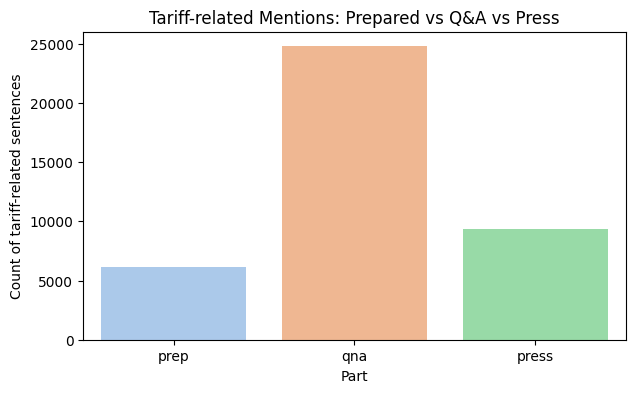

    part  count
0   prep   6132
1    qna  24774
2  press   9382


In [58]:
# ==== Barplot: tariff mentions in Prepared vs Q&A vs Press ====

# Call 部分
call_counts = call_sents.groupby('part')['sentence'].count().reset_index()

# Press 部分（统一标记 part='press'）
press_counts = press_sents.groupby('source')['sentence'].count().reset_index()
press_counts = press_counts.rename(columns={'source':'part', 'sentence':'count'})
press_counts['part'] = 'press'

# 为了对齐列名，把 call_counts 也改成 'count'
call_counts = call_counts.rename(columns={'sentence':'count'})

# 合并
all_counts = pd.concat([call_counts, press_counts], ignore_index=True)

# 画图
plt.figure(figsize=(7,4))
sns.barplot(data=all_counts, x='part', y='count', palette='pastel')
plt.title("Tariff-related Mentions: Prepared vs Q&A vs Press")
plt.xlabel("Part")
plt.ylabel("Count of tariff-related sentences")
plt.show()

print(all_counts)


In [59]:
# Count NaT values
nat_count = press_sents['fiscal_quarter'].isna().sum()
print(f"Number of NaT values: {nat_count}")

# View rows with NaT values
nat_rows = press_sents[press_sents['fiscal_quarter'].isna()]
print(nat_rows[['ticker', 'fiscal_quarter']].head())

Number of NaT values: 0
Empty DataFrame
Columns: [ticker, fiscal_quarter]
Index: []


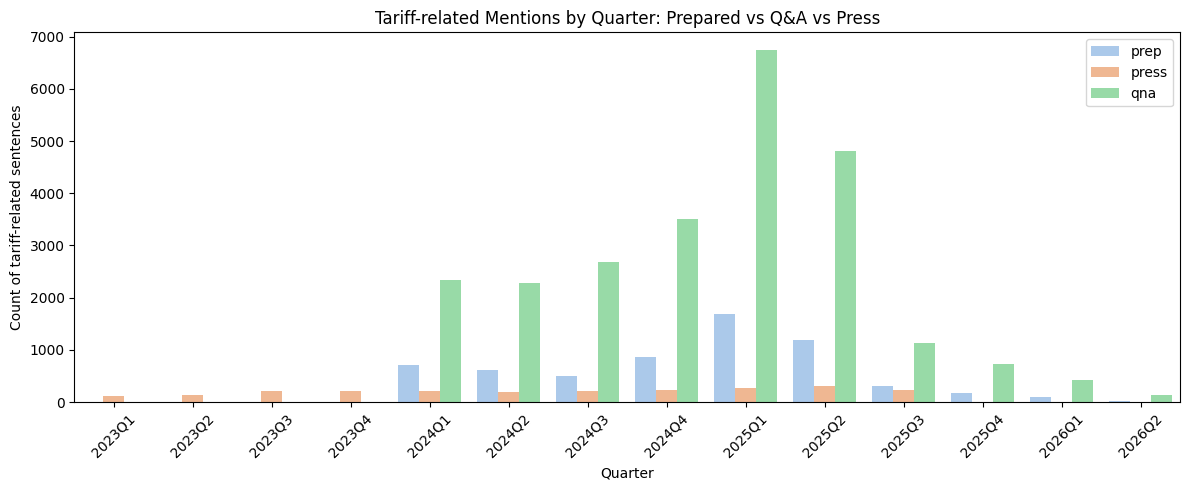

part,fiscal_quarter,prep,press,qna
0,2023Q1,0.0,110.0,0.0
1,2023Q2,0.0,134.0,0.0
2,2023Q3,0.0,202.0,0.0
3,2023Q4,0.0,215.0,0.0
4,2024Q1,709.0,208.0,2330.0


In [41]:
# ### P4.x Mentions by Quarter: Grouped Bars (Prep vs Q&A vs Press)
# Column Needed：call_sents['fiscal_quarter','part','sentence']、press_sents['fiscal_quarter','sentence']

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Drop NaT in fiscal_quarter to avoid "NaT" in plots (includes string 'NaT')
call_sents = call_sents[call_sents['fiscal_quarter'].notna() & (call_sents['fiscal_quarter'] != 'NaT')]
press_sents = press_sents[press_sents['fiscal_quarter'].notna() & (press_sents['fiscal_quarter'] != 'NaT')]

# 1)  call：by quarter × part
call_q = (call_sents
          .groupby(['fiscal_quarter','part'])['sentence']
          .count()
          .reset_index(name='count'))

# 2) press：by quarter
press_q = (press_sents
           .groupby(['fiscal_quarter'])['sentence']
           .count()
           .reset_index(name='count'))
press_q['part'] = 'press'

# 3) Merge call + press, fill missing with 0
all_q = pd.concat([call_q, press_q], ignore_index=True)
all_q = (all_q
         .pivot(index='fiscal_quarter', columns='part', values='count')
         .fillna(0)
         .reset_index())

# 4) Plot grouped bar chart
plot_df = all_q.melt(id_vars='fiscal_quarter', var_name='part', value_name='count')
plt.figure(figsize=(12,5))
sns.barplot(data=plot_df, x='fiscal_quarter', y='count', hue='part', palette='pastel')
plt.title("Tariff-related Mentions by Quarter: Prepared vs Q&A vs Press")
plt.xlabel("Quarter"); plt.ylabel("Count of tariff-related sentences")
plt.xticks(rotation=45)
plt.legend(title="")
plt.tight_layout()
plt.show()

display(all_q.head())

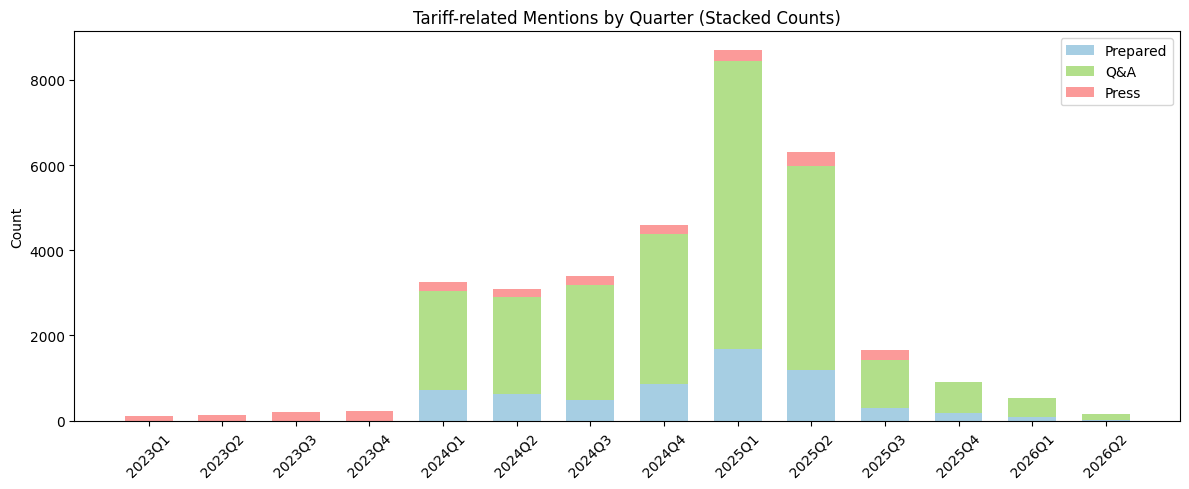

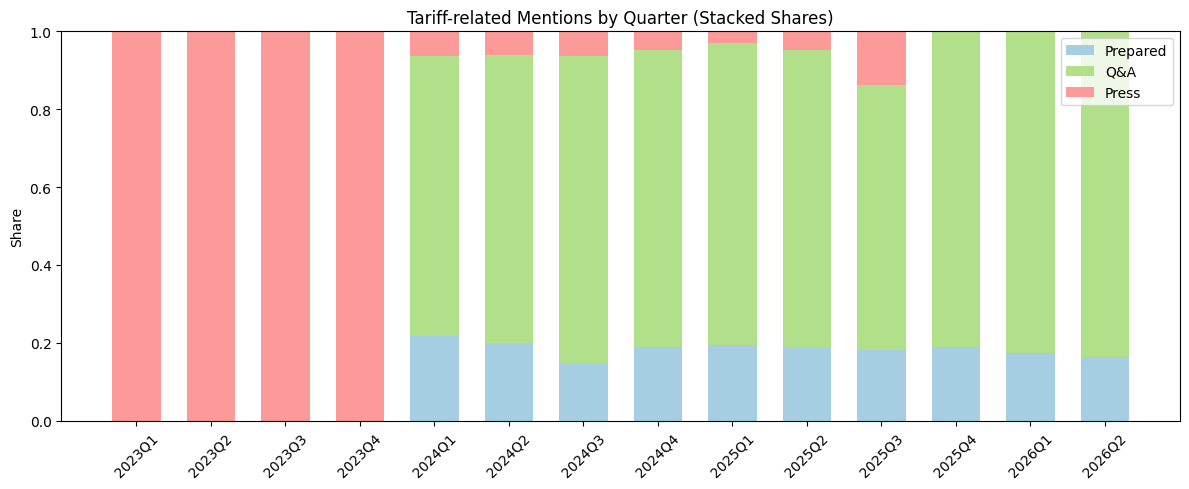

In [ ]:
# ### P4.x Mentions by Quarter: Stacked Bars (share & total)

import numpy as np
import matplotlib.pyplot as plt

# 复用上一个 cell 里构造好的 all_q（宽表：['fiscal_quarter','prep','press','qna'] 之类）
# 如果上一格没执行，就重新构造一次 all_q：
try:
    all_q
except NameError:
    # Drop NaT in fiscal_quarter to avoid "NaT" in plots (includes string 'NaT')
    call_sents_filtered = call_sents[call_sents['fiscal_quarter'].notna() & (call_sents['fiscal_quarter'] != 'NaT')]
    press_sents_filtered = press_sents[press_sents['fiscal_quarter'].notna() & (press_sents['fiscal_quarter'] != 'NaT')]

    call_q = (call_sents_filtered.groupby(['fiscal_quarter','part'])['sentence']
              .count().reset_index(name='count'))
    press_q = (press_sents_filtered.groupby(['fiscal_quarter'])['sentence']
               .count().reset_index(name='count'))
    press_q['part'] = 'press'
    all_q = pd.concat([call_q, press_q], ignore_index=True)\
              .pivot(index='fiscal_quarter', columns='part', values='count')\
              .fillna(0).reset_index()

# 确保列顺序（没有的列自动补 0）
for c in ['prep','qna','press']:
    if c not in all_q.columns:
        all_q[c] = 0

# 1) 画“数量”堆叠
quarters = all_q['fiscal_quarter'].tolist()
prep = all_q['prep'].to_numpy()
qna  = all_q['qna'].to_numpy()
pr   = all_q['press'].to_numpy()

x = np.arange(len(quarters))
width = 0.65

plt.figure(figsize=(12,5))
p1 = plt.bar(x, prep, width, label='Prepared', color='#a6cee3')
p2 = plt.bar(x, qna,  width, bottom=prep, label='Q&A', color='#b2df8a')
p3 = plt.bar(x, pr,   width, bottom=prep+qna, label='Press', color='#fb9a99')
plt.xticks(x, quarters, rotation=45)
plt.ylabel("Count"); plt.title("Tariff-related Mentions by Quarter (Stacked Counts)")
plt.legend()
plt.tight_layout()
plt.show()

# 2) 画“占比”堆叠
tot = prep + qna + pr
# 避免除以 0
tot_safe = np.where(tot==0, 1, tot)
prep_s = prep / tot_safe
qna_s  = qna  / tot_safe
pr_s   = pr   / tot_safe

plt.figure(figsize=(12,5))
p1 = plt.bar(x, prep_s, width, label='Prepared', color='#a6cee3')
p2 = plt.bar(x, qna_s,  width, bottom=prep_s, label='Q&A', color='#b2df8a')
p3 = plt.bar(x, pr_s,   width, bottom=prep_s+qna_s, label='Press', color='#fb9a99')
plt.xticks(x, quarters, rotation=45)
plt.ylabel("Share"); plt.title("Tariff-related Mentions by Quarter (Stacked Shares)")
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...


### Analyzing by sector (forgot this)

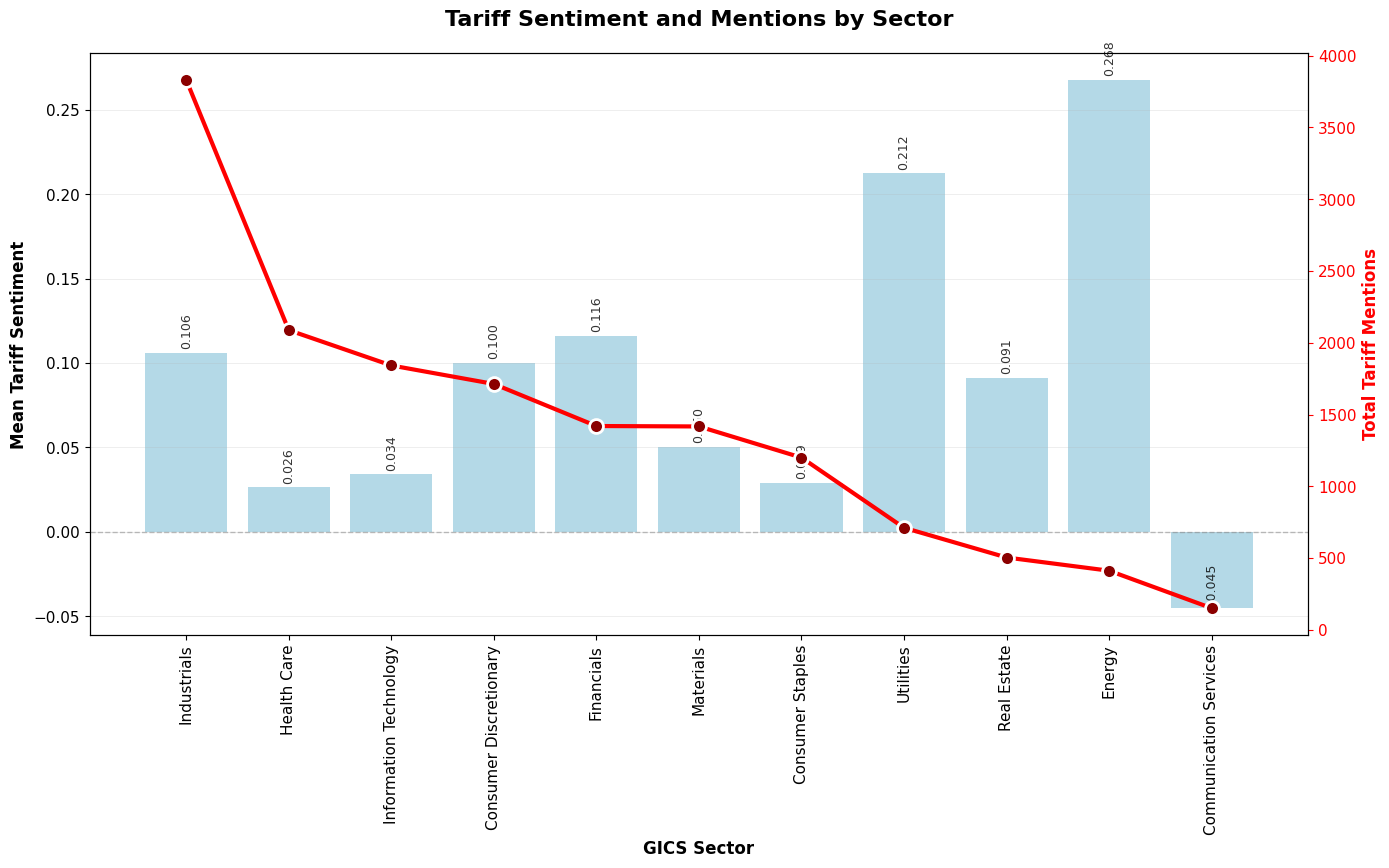


Sector Analysis Summary:
Industrials                   : Sentiment =  0.106, Mentions = 3832
Health Care                   : Sentiment =  0.026, Mentions = 2088
Information Technology        : Sentiment =  0.034, Mentions = 1842
Consumer Discretionary        : Sentiment =  0.100, Mentions = 1713
Financials                    : Sentiment =  0.116, Mentions = 1420
Materials                     : Sentiment =  0.050, Mentions = 1417
Consumer Staples              : Sentiment =  0.029, Mentions = 1200
Utilities                     : Sentiment =  0.212, Mentions =  711
Real Estate                   : Sentiment =  0.091, Mentions =  504
Energy                        : Sentiment =  0.268, Mentions =  412
Communication Services        : Sentiment = -0.045, Mentions =  151


In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a graph showing tariff sentiment by sector
# First, we need to merge sector information with our tariff sentiment data

# 1. Get sector information
if 'GICS_Sector' in press_std.columns:
    # Create a mapping from ticker to sector
    sector_map = press_std[['ticker', 'GICS_Sector']].drop_duplicates().set_index('ticker')
    
    # Merge with tariff sentiment data
    tariff_with_sectors = tariff_panel_emb.merge(
        sector_map, on='ticker', how='left'
    )
    
    # Aggregate sentiment by sector
    sector_sentiment = tariff_with_sectors.groupby('GICS_Sector')[
        ['TariffSent_mean_call_all', 'TariffMentions_call_all']
    ].agg({
        'TariffSent_mean_call_all': 'mean',
        'TariffMentions_call_all': 'sum'
    }).reset_index()
    
    # Sort by mentions to highlight most impacted sectors
    sector_sentiment = sector_sentiment.sort_values('TariffMentions_call_all', ascending=False)
    
    # Plot with improved formatting
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot sentiment bars
    bars = sns.barplot(
        x='GICS_Sector', 
        y='TariffSent_mean_call_all', 
        data=sector_sentiment,
        color='skyblue',
        ax=ax1,
        alpha=0.7
    )
    
    # Add a line for the mentions (secondary axis)
    ax2 = ax1.twinx()
    ax2.plot(
        range(len(sector_sentiment)), 
        sector_sentiment['TariffMentions_call_all'], 
        'o-', 
        color='red', 
        linewidth=3,
        markersize=10,
        markerfacecolor='darkred',
        markeredgecolor='white',
        markeredgewidth=2
    )
    
    # Set labels and title
    ax1.set_xlabel('GICS Sector', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Mean Tariff Sentiment', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Total Tariff Mentions', color='red', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', colors='red', labelsize=11)
    
    plt.title('Tariff Sentiment and Mentions by Sector', fontsize=16, fontweight='bold', pad=20)
    
    # Make sector names vertical and improve readability
    plt.setp(ax1.get_xticklabels(), rotation=90, ha='center', fontsize=11)
    ax1.tick_params(axis='y', labelsize=11)
    
    # Add a horizontal line at y=0 for reference
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Improve grid
    ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add value annotations on bars (optional)
    for i, (bar, mentions) in enumerate(zip(bars.patches, sector_sentiment['TariffMentions_call_all'])):
        if mentions > 0:  # Only annotate if there are mentions
            height = bar.get_height()
            ax1.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=9, rotation=90,
                        alpha=0.8)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Extra space for vertical labels
    
    plt.show()
    
    # Print summary statistics
    print("\nSector Analysis Summary:")
    print("=" * 50)
    for _, row in sector_sentiment.iterrows():
        print(f"{row['GICS_Sector']:<30}: "
              f"Sentiment = {row['TariffSent_mean_call_all']:6.3f}, "
              f"Mentions = {int(row['TariffMentions_call_all']):4d}")
    
else:
    # Alternative approach if sector data is not directly available
    print("No sector information found in the available dataframes.")
    
    # Try to use other dataframe like df_main if it contains sector information
    if 'df_main' in locals() and 'GICS_Sector' in df_main.columns:
        sector_map = df_main[['ticker', 'GICS_Sector']].drop_duplicates().set_index('ticker')
        
        # Merge with tariff sentiment data
        tariff_with_sectors = tariff_panel_emb.merge(
            sector_map, on='ticker', how='left'
        )
        
        # Continue with the same aggregation and plotting logic as above
        sector_sentiment = tariff_with_sectors.groupby('GICS_Sector')[
            ['TariffSent_mean_call_all', 'TariffMentions_call_all']
        ].agg({
            'TariffSent_mean_call_all': 'mean',
            'TariffMentions_call_all': 'sum'
        }).reset_index()
        
        # Sort and plot (same code as above)
        sector_sentiment = sector_sentiment.sort_values('TariffMentions_call_all', ascending=False)
        
        # [Same plotting code would go here]
        
    else:
        print("Please provide a dataframe with GICS_Sector information to create sector analysis.")
        
        # Show what dataframes and columns are available for debugging
        print("\nAvailable dataframes and their columns:")
        for df_name in ['tariff_panel_emb', 'press_std', 'df_main']:
            if df_name in locals():
                df_obj = locals()[df_name]
                print(f"{df_name}: {list(df_obj.columns)}")
            else:
                print(f"{df_name}: Not available")